In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime

from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings('ignore')
#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# 1. Data Understanding / Preparation

## 1.1 Data Retrieval

In [2]:
# Reading Accounts' Data
acc = pd.read_csv("./processed/account.csv", sep=";")

# Reading Transactions' Data
trans = pd.read_csv("./processed/trans_dev.csv", sep=";");
#trans = pd.read_csv("./processed/trans_comp.csv", sep=";");

# Reading Loans' Data
loan = pd.read_csv("./processed/loan_dev.csv", sep=";");
#loan = pd.read_csv("./processed/loan_comp.csv", sep=";");

# Reading Districts' Data
dist = pd.read_csv("./raw/district.csv", sep=";");

# Reading Disponents' Data
disp = pd.read_csv("./processed/disp.csv", sep=";");

# Reading Cards' Data
card = pd.read_csv("./processed/card_dev.csv", sep=";");
#card = pd.read_csv("./processed/card_comp.csv", sep=";");

# Reading Clients' Data
clie = pd.read_csv("./processed/client.csv", sep=";");

In [3]:
# Confirming all files were read successfully.
# General overview of number of attributes (columns) and entries (rows) per table, missing values, types of variables.
#for df in [acc, trans, loan, dist, disp, card, clie]:
#    print(df.info())
#    print("\n")

## 1.2 Data Integration - Grouping all columns of all files into a single dataframe

In [4]:
# Merging Accounts' and Transactions' Data

complete = pd.merge(acc, pd.DataFrame(trans.groupby('account_id').size(), columns=['# trans']), right_index=True, left_on='account_id', how="outer")

# Oper 1 - credit in cash, Oper 2 - credit card withdrawal, Oper 3 - collection from another bank, Oper 4 - remittance to another bank, Oper 5 - withdrawal in cash
complete = pd.merge(complete, pd.DataFrame(trans[trans['operation']=='credit in cash'].groupby('account_id').size(), columns=['oper #1']), right_index=True, left_on='account_id', how="outer")
complete = pd.merge(complete, pd.DataFrame(trans[trans['operation']=='credit card withdrawal'].groupby('account_id').size(), columns=['oper #2']), right_index=True, left_on='account_id', how="outer")
complete = pd.merge(complete, pd.DataFrame(trans[trans['operation']=='collection from another bank'].groupby('account_id').size(), columns=['oper #3']), right_index=True, left_on='account_id', how="outer")
complete = pd.merge(complete, pd.DataFrame(trans[trans['operation']=='remittance to another bank'].groupby('account_id').size(), columns=['oper #4']), right_index=True, left_on='account_id', how="outer")
complete = pd.merge(complete, pd.DataFrame(trans[trans['operation']=='withdrawal in cash'].groupby('account_id').size(), columns=['oper #5']), right_index=True, left_on='account_id', how="outer")

# Type 1 - withdrawal, Type 2 - withdrawal in cash, Type 3 - credit 
complete = pd.merge(complete, pd.DataFrame(trans[trans['type']=='withdrawal'].groupby('account_id').size(), columns=['type #1']), right_index=True, left_on='account_id', how="outer")
complete = pd.merge(complete, pd.DataFrame(trans[trans['type']=='withdrawal in cash'].groupby('account_id').size(), columns=['type #2']), right_index=True, left_on='account_id', how="outer")
complete = pd.merge(complete, pd.DataFrame(trans[trans['type']=='credit'].groupby('account_id').size(), columns=['type #3']), right_index=True, left_on='account_id', how="outer")

complete = pd.merge(complete, pd.DataFrame(trans.groupby('account_id').amount.mean().round(2)).rename(columns={'amount':'avg trans amount'}), right_index=True, left_on='account_id', how="outer")
complete = pd.merge(complete, pd.DataFrame(trans.groupby('account_id').balance.mean().round(2)).rename(columns={'balance':'avg trans balance'}), right_index=True, left_on='account_id', how="outer")
# (4500, 15)

# ------------------------

# Merging with Loans' Data
complete = pd.merge(complete, loan.rename(columns={'date': 'loan date', 'amount': 'loan amount', 'duration': 'loan duration (mths)', 'payments': 'loan payments', 'status': 'loan status'}))
# (328, 21)

# ------------------------

# Merging with Districts' Data
complete = pd.merge(complete, dist.rename(columns={'code ': 'district_id', 'name ': 'district_name', 'region': 'district_region'}))
# (328, 36)

# ------------------------

# Merging Disp' and Cards' Data
disp = disp.rename(columns={"type": "disp type"})
disp['has disponent'] = np.where(disp['disp type'] == 'DISPONENT', True, False)
card = card.rename(columns={"type": "card type"})
disp_card = pd.merge(disp, card, how="outer")
# (5369, 9)

# ------------------------

# Merging Previous with Clients' Data
disp_card_clie = pd.merge(disp_card, clie).drop_duplicates(subset=['account_id']).drop(columns=['has disponent', 'disp type', 'disp_id'])
# (4500, 7)
temp = pd.merge(disp_card_clie, pd.DataFrame(disp_card.groupby('account_id').size(), columns = ['count owner']), right_index=True, left_on='account_id', how="outer")
disp_card_clie['has disponent'] = np.where(temp['count owner'] == 2, True, False)
# (4500, 8)

# ------------------------

# Merging Previous subset with the rest
complete = pd.merge(complete, disp_card_clie)


print(complete.shape)
complete


(268, 43)


account_id  district_id         frequency        date  # trans  oper #1  \
0          5270           44  monthly issuance  1993-01-13     53.0      1.0   
1          5385           44   weekly issuance  1993-05-21     56.0      3.0   
2          3037           44  monthly issuance  1994-05-26    117.0     26.0   
3         10942           44   weekly issuance  1994-06-05    130.0     40.0   
4         11265           15  monthly issuance  1993-01-14     43.0     14.0   
..          ...          ...               ...         ...      ...      ...   
263        4462           73   weekly issuance  1995-12-27     10.0      4.0   
264        5001           53  monthly issuance  1995-12-15     82.0     27.0   
265        3084           59   weekly issuance  1996-01-28     29.0      8.0   
266       11054           59   weekly issuance  1996-02-01     31.0      3.0   
267        8680           17  monthly issuance  1996-02-12     19.0      2.0   

     oper #2  oper #3  oper #4  oper #5  type #1  type #2  type #3  \
0        NaN     11.0      NaN     31.0     28.0      3.0     22.0   
1        NaN     10.0      6.0     27.0     32.0      1.0     23.0   
2        NaN      NaN      NaN     71.0     70.0      1.0     46.0   
3        NaN      NaN     12.0     62.0     72.0      2.0     56.0   
4        NaN      NaN      8.0     14.0     22.0      NaN     21.0   
..       ...      ...      ...      ...      ...      ...      ...   
263      NaN      NaN      NaN      3.0      3.0      NaN      7.0   
264      NaN      NaN      6.0     39.0     41.0      4.0     37.0   
265      NaN      NaN      NaN     15.0     13.0      2.0     14.0   
266      NaN      7.0      3.0     12.0     14.0      1.0     16.0   
267      NaN      5.0      NaN      4.0      4.0      NaN     15.0   

     avg trans amount  avg trans balance  loan_id   loan date  loan amount  \
0            17600.36           69954.57     6077  1993-11-22        79608   
1             5778.79           29069.12     6103  1994-04-07       149340   
2            10720.31           46487.00     5593  1996-04-18       277884   
3            15168.36           63527.42     7227  1995-10-02       314520   
4             3714.90           22198.18     7284  1993-09-15        52788   
..                ...                ...      ...         ...          ...   
263          13609.12           34798.28     5892  1996-05-14        66480   
264          17234.72           76232.70     6015  1996-11-09       110112   
265          11379.26           37095.84     5606  1996-08-28       253512   
266           7832.08           32435.32     7246  1996-08-20       148920   
267           7206.16           31337.26     6751  1996-07-14        85716   

     loan duration (mths)  loan payments  loan status  district_name  \
0                      24           3317            1        Chrudim   
1                      60           2489            1        Chrudim   
2                      36           7719           -1        Chrudim   
3                      60           5242            1        Chrudim   
4                      12           4399            1  Cesky Krumlov   
..                    ...            ...          ...            ...   
263                    24           2770           -1          Opava   
264                    24           4588            1        Blansko   
265                    36           7042           -1       Kromeriz   
266                    60           2482            1       Kromeriz   
267                    36           2381            1      Pelhrimov   

    district_region  no. of inhabitants  \
0      east Bohemia              105606   
1      east Bohemia              105606   
2      east Bohemia              105606   
3      east Bohemia              105606   
4     south Bohemia               58796   
..              ...                 ...   
263   north Moravia              182027   
264   south Moravia              107911   
265   south Mo

### 1.2.1 Replacing by 0 columns refering to number of transactions (operations / types) that are NaN (weren't filled in

In [5]:
# NaN value is present in # operation / # type columns and represents that 0 were found. Therefore 0 is a more suitable value.
for col in ['oper #1', 'oper #2', 'oper #3', 'oper #4', 'oper #5', 'type #1', 'type #2', 'type #3']:
    complete[col] = complete[col].fillna(0)
    
complete.head()

account_id  district_id         frequency        date  # trans  oper #1  \
0        5270           44  monthly issuance  1993-01-13     53.0      1.0   
1        5385           44   weekly issuance  1993-05-21     56.0      3.0   
2        3037           44  monthly issuance  1994-05-26    117.0     26.0   
3       10942           44   weekly issuance  1994-06-05    130.0     40.0   
4       11265           15  monthly issuance  1993-01-14     43.0     14.0   

   oper #2  oper #3  oper #4  oper #5  type #1  type #2  type #3  \
0      0.0     11.0      0.0     31.0     28.0      3.0     22.0   
1      0.0     10.0      6.0     27.0     32.0      1.0     23.0   
2      0.0      0.0      0.0     71.0     70.0      1.0     46.0   
3      0.0      0.0     12.0     62.0     72.0      2.0     56.0   
4      0.0      0.0      8.0     14.0     22.0      0.0     21.0   

   avg trans amount  avg trans balance  loan_id   loan date  loan amount  \
0          17600.36           69954.57     6077  1993-11-22        79608   
1           5778.79           29069.12     6103  1994-04-07       149340   
2          10720.31           46487.00     5593  1996-04-18       277884   
3          15168.36           63527.42     7227  1995-10-02       314520   
4           3714.90           22198.18     7284  1993-09-15        52788   

   loan duration (mths)  loan payments  loan status  district_name  \
0                    24           3317            1        Chrudim   
1                    60           2489            1        Chrudim   
2                    36           7719           -1        Chrudim   
3                    60           5242            1        Chrudim   
4                    12           4399            1  Cesky Krumlov   

  district_region  no. of inhabitants  \
0    east Bohemia              105606   
1    east Bohemia              105606   
2    east Bohemia              105606   
3    east Bohemia              105606   
4   south Bohemia               58796   

   no. of municipalities with inhabitants < 499   \
0                                             77   
1                                             77   
2                                             77   
3                                             77   
4                                             22   

   no. of municipalities with inhabitants 500-1999  \
0                                               26   
1                                               26   
2                                               26   
3                                               26   
4                                               16   

   no. of municipalities with inhabitants 2000-9999   \
0                                                  7   
1                                                  7   
2                                                  7   
3                                                  7   
4                                                  7   

   no. of municipalities with inhabitants >10000   no. of cities   \
0                                               2               7   
1                                               2               7   
2                                               2               7   
3                                               2               7   
4                                               1               5   

   ratio of urban inhabitants   average salary  unemploymant rate '95   \
0                         53.0             8254                   2.79   
1                         53.0             8254                   2.79   
2                         53.0             8254                   2.79   
3                         53.0             8254                   2.79   
4                         51.9             9045                   3.13   

   unemploymant rate '96   no. of enterpreneurs per 1000 inhabitants   \
0                    3.76                                          97   
1                  

### 1.2.2 Deleting columns whose only purpose was to help in the join of tables (IDs) and/or are redundant

In [6]:
# Removing attributes. district_name / district_region are redundant because they can be derived by the rest of the district columns
complete = complete.drop(columns=['account_id', 'district_name', 'district_region', 'client_id', 'card_id'])

# Doesn't seem to be useful, especially considering the very limited amount of data related to cards
complete = complete.drop(columns=['issued'])

print(complete.shape)
complete.columns

(268, 37)


Index(['district_id', 'frequency', 'date', '# trans', 'oper #1', 'oper #2',
       'oper #3', 'oper #4', 'oper #5', 'type #1', 'type #2', 'type #3',
       'avg trans amount', 'avg trans balance', 'loan_id', 'loan date',
       'loan amount', 'loan duration (mths)', 'loan payments', 'loan status',
       'no. of inhabitants', 'no. of municipalities with inhabitants < 499 ',
       'no. of municipalities with inhabitants 500-1999',
       'no. of municipalities with inhabitants 2000-9999 ',
       'no. of municipalities with inhabitants >10000 ', 'no. of cities ',
       'ratio of urban inhabitants ', 'average salary ',
       'unemploymant rate '95 ', 'unemploymant rate '96 ',
       'no. of enterpreneurs per 1000 inhabitants ',
       'no. of commited crimes '95 ', 'no. of commited crimes '96 ',
       'card type', 'birthdate', 'sex', 'has disponent'],
      dtype='object')

In [7]:
complete = complete.rename(columns={'date': 'acc date'})
complete.columns

Index(['district_id', 'frequency', 'acc date', '# trans', 'oper #1', 'oper #2',
       'oper #3', 'oper #4', 'oper #5', 'type #1', 'type #2', 'type #3',
       'avg trans amount', 'avg trans balance', 'loan_id', 'loan date',
       'loan amount', 'loan duration (mths)', 'loan payments', 'loan status',
       'no. of inhabitants', 'no. of municipalities with inhabitants < 499 ',
       'no. of municipalities with inhabitants 500-1999',
       'no. of municipalities with inhabitants 2000-9999 ',
       'no. of municipalities with inhabitants >10000 ', 'no. of cities ',
       'ratio of urban inhabitants ', 'average salary ',
       'unemploymant rate '95 ', 'unemploymant rate '96 ',
       'no. of enterpreneurs per 1000 inhabitants ',
       'no. of commited crimes '95 ', 'no. of commited crimes '96 ',
       'card type', 'birthdate', 'sex', 'has disponent'],
      dtype='object')

### 1.2.3 Account id as index

In [8]:
complete = complete.set_index('loan_id')

In [9]:
complete['age_at_loan'] = (pd.to_datetime(complete['loan date']) - pd.to_datetime(complete['birthdate'])).dt.total_seconds() / (365.25*24*3600)
complete['acc_age_at_loan'] = (pd.to_datetime(complete['loan date']) - pd.to_datetime(complete['acc date'])).dt.total_seconds() / (365.25*24*3600)

In [10]:
complete.loc[complete["unemploymant rate '95 "] == '?', "unemploymant rate '95 "] = complete["unemploymant rate '96 "]
complete.loc[complete["unemploymant rate '96 "] == '?', "unemploymant rate '96 "] = complete["unemploymant rate '95 "]

In [11]:
complete["unemploymant rate"] = (complete["unemploymant rate '95 "].astype('float') + complete["unemploymant rate '96 "].astype('float')) / 2.0
complete = complete.drop(columns=["unemploymant rate '95 ", "unemploymant rate '96 "])

In [12]:
complete.loc[complete["no. of commited crimes '95 "] == '?', "no. of commited crimes '95 "] = complete["no. of commited crimes '96 "]
complete.loc[complete["no. of commited crimes '96 "] == '?', "no. of commited crimes '96 "] = complete["no. of commited crimes '95 "]

In [13]:
complete["no. of commited crimes per capita"] = (complete["no. of commited crimes '95 "].astype('float') + complete["no. of commited crimes '96 "].astype('float')) / 2.0 / complete["no. of inhabitants"]
complete = complete.drop(columns=["no. of commited crimes '95 ", "no. of commited crimes '96 "])

In [14]:
complete['card type'] = complete['card type'].fillna('None')

In [15]:
#complete.loc[complete['age at loan (Years)'] < 18]

In [16]:
complete.columns

Index(['district_id', 'frequency', 'acc date', '# trans', 'oper #1', 'oper #2',
       'oper #3', 'oper #4', 'oper #5', 'type #1', 'type #2', 'type #3',
       'avg trans amount', 'avg trans balance', 'loan date', 'loan amount',
       'loan duration (mths)', 'loan payments', 'loan status',
       'no. of inhabitants', 'no. of municipalities with inhabitants < 499 ',
       'no. of municipalities with inhabitants 500-1999',
       'no. of municipalities with inhabitants 2000-9999 ',
       'no. of municipalities with inhabitants >10000 ', 'no. of cities ',
       'ratio of urban inhabitants ', 'average salary ',
       'no. of enterpreneurs per 1000 inhabitants ', 'card type', 'birthdate',
       'sex', 'has disponent', 'age_at_loan', 'acc_age_at_loan',
       'unemploymant rate', 'no. of commited crimes per capita'],
      dtype='object')

In [17]:
complete = complete[['loan status', 'frequency', 'acc date', '# trans', 'oper #1', 'oper #2', 'oper #3',
       'oper #4', 'oper #5', 'type #1', 'type #2', 'type #3',
       'avg trans amount', 'avg trans balance', 'loan date', 'loan amount',
       'loan duration (mths)', 'loan payments',
       'no. of inhabitants', 'no. of municipalities with inhabitants < 499 ',
       'no. of municipalities with inhabitants 500-1999',
       'no. of municipalities with inhabitants 2000-9999 ',
       'no. of municipalities with inhabitants >10000 ', 'no. of cities ',
       'ratio of urban inhabitants ', 'average salary ',
       'no. of enterpreneurs per 1000 inhabitants ', 'card type', 'birthdate',
       'sex', 'has disponent', 'age_at_loan', 'acc_age_at_loan',
       'unemploymant rate', 'no. of commited crimes per capita', 'district_id']]
complete.shape

(268, 36)

In [18]:
complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 268 entries, 6077 to 6751
Data columns (total 36 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   loan status                                        268 non-null    int64  
 1   frequency                                          268 non-null    object 
 2   acc date                                           268 non-null    object 
 3   # trans                                            268 non-null    float64
 4   oper #1                                            268 non-null    float64
 5   oper #2                                            268 non-null    float64
 6   oper #3                                            268 non-null    float64
 7   oper #4                                            268 non-null    float64
 8   oper #5                                            268 non-null    float64
 9   type #

In [19]:
complete.columns

Index(['loan status', 'frequency', 'acc date', '# trans', 'oper #1', 'oper #2',
       'oper #3', 'oper #4', 'oper #5', 'type #1', 'type #2', 'type #3',
       'avg trans amount', 'avg trans balance', 'loan date', 'loan amount',
       'loan duration (mths)', 'loan payments', 'no. of inhabitants',
       'no. of municipalities with inhabitants < 499 ',
       'no. of municipalities with inhabitants 500-1999',
       'no. of municipalities with inhabitants 2000-9999 ',
       'no. of municipalities with inhabitants >10000 ', 'no. of cities ',
       'ratio of urban inhabitants ', 'average salary ',
       'no. of enterpreneurs per 1000 inhabitants ', 'card type', 'birthdate',
       'sex', 'has disponent', 'age_at_loan', 'acc_age_at_loan',
       'unemploymant rate', 'no. of commited crimes per capita',
       'district_id'],
      dtype='object')

In [20]:
for column in ['acc date', 'loan date', 'birthdate']:
    complete[column] = pd.to_datetime(complete[column])

In [21]:
def ordinal_encode(df, column, ordering):
    df = df.copy()
    df[column] = df[column].apply(lambda x : ordering.index(x))
    return df

def special_binary_encode(df, column, negative_value):
    df = df.copy()
    df['card_owner'] = df[column].apply(lambda x : 0 if x == negative_value else 1)
    # df = df.drop(column, axis=1)
    return df

In [22]:
# Experiment with encoding

#complete['account_year'] = complete['acc date'].apply(lambda x : x.year)
#complete['account_month'] = complete['acc date'].apply(lambda x : x.month)
#complete['account_day'] = complete['acc date'].apply(lambda x : x.day)

#complete['loan_year'] = complete['loan date'].apply(lambda x : x.year)
#complete['loan_month'] = complete['loan date'].apply(lambda x : x.month)
#complete['loan_day'] = complete['loan date'].apply(lambda x : x.day)

#complete['birth_year'] = complete['birthdate'].apply(lambda x : x.year)
#complete['birth_month'] = complete['birthdate'].apply(lambda x : x.month)
#complete['birth_day'] = complete['birthdate'].apply(lambda x : x.day)

#complete = complete.drop(['acc date', 'loan date', 'birthdate'], axis=1)

#freq_ordering = [
#    'monthly issuance',
#    'weekly issuance',
#    'issuance after transaction'
#]
#complete = ordinal_encode(complete, 'frequency', ordering=freq_ordering)


# Commented for statistical analysis:

#complete = pd.get_dummies(complete, columns=['frequency'])

#complete = special_binary_encode(complete, 'card type', negative_value='None')

#complete = pd.get_dummies(complete, columns=['card type'])

## 1.3 Complete ('joined') data

In [23]:
complete

loan status         frequency   acc date  # trans  oper #1  oper #2  \
loan_id                                                                        
6077               1  monthly issuance 1993-01-13     53.0      1.0      0.0   
6103               1   weekly issuance 1993-05-21     56.0      3.0      0.0   
5593              -1  monthly issuance 1994-05-26    117.0     26.0      0.0   
7227               1   weekly issuance 1994-06-05    130.0     40.0      0.0   
7284               1  monthly issuance 1993-01-14     43.0     14.0      0.0   
...              ...               ...        ...      ...      ...      ...   
5892              -1   weekly issuance 1995-12-27     10.0      4.0      0.0   
6015               1  monthly issuance 1995-12-15     82.0     27.0      0.0   
5606              -1   weekly issuance 1996-01-28     29.0      8.0      0.0   
7246               1   weekly issuance 1996-02-01     31.0      3.0      0.0   
6751               1  monthly issuance 1996-02-12     19.0      2.0      0.0   

         oper #3  oper #4  oper #5  type #1  type #2  type #3  \
loan_id                                                         
6077        11.0      0.0     31.0     28.0      3.0     22.0   
6103        10.0      6.0     27.0     32.0      1.0     23.0   
5593         0.0      0.0     71.0     70.0      1.0     46.0   
7227         0.0     12.0     62.0     72.0      2.0     56.0   
7284         0.0      8.0     14.0     22.0      0.0     21.0   
...          ...      ...      ...      ...      ...      ...   
5892         0.0      0.0      3.0      3.0      0.0      7.0   
6015         0.0      6.0     39.0     41.0      4.0     37.0   
5606         0.0      0.0     15.0     13.0      2.0     14.0   
7246         7.0      3.0     12.0     14.0      1.0     16.0   
6751         5.0      0.0      4.0      4.0      0.0     15.0   

         avg trans amount  avg trans balance  loan date  loan amount  \
loan_id                                                                
6077             17600.36           69954.57 1993-11-22        79608   
6103              5778.79           29069.12 1994-04-07       149340   
5593             10720.31           46487.00 1996-04-18       277884   
7227             15168.36           63527.42 1995-10-02       314520   
7284              3714.90           22198.18 1993-09-15        52788   
...                   ...                ...        ...          ...   
5892             13609.12           34798.28 1996-05-14        66480   
6015             17234.72           76232.70 1996-11-09       110112   
5606             11379.26           37095.84 1996-08-28       253512   
7246              7832.08           32435.32 1996-08-20       148920   
6751              7206.16           31337.26 1996-07-14        85716   

         loan duration (mths)  loan payments  no. of inhabitants  \
loan_id                                                            
6077                       24           3317              105606   
6103                       60           2489              105606   
5593                       36           7719              105606   
7227                       60           5242              105606   
7284                       12           4399               58796   
...                       ...            ...                 ...   
5892                       24           2770              182027   
6015                       24           4588              107911   
5606                       36           7042              108871   
7246                       60           2482              108871   
6751                       36           2381               74062   

         no. of municipalities with inhabitants < 499   \
loan_id                                                  
6077                                                77   
6103                                                77   
5593                                                77   
7227      

### 1.3.1 Exporting to csv

In [24]:
#complete.to_csv("./last_dev_complete_data_2.csv", sep=";")
#complete.to_csv("./last_comp_complete_data.csv", sep=";")

## 1.4 Data Analysis

### 1.4.1 Frequency - Nominal Categorical Attribute

In [25]:
complete['frequency'].describe()

count                  268
unique                   3
top       monthly issuance
freq                   211
Name: frequency, dtype: object

<AxesSubplot:>

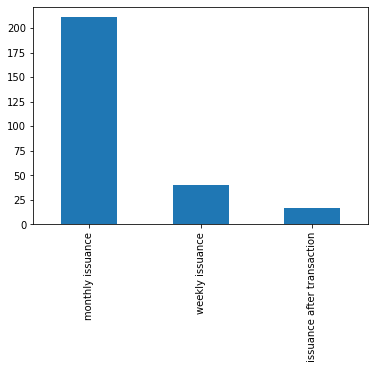

In [26]:
complete['frequency'].value_counts().plot(kind='bar')

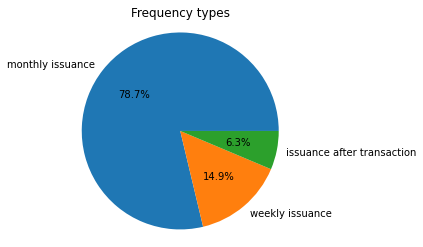

In [27]:
fig, ax = plt.subplots()
ax.pie(complete['frequency'].value_counts(), labels=complete['frequency'].unique(), autopct='%1.1f%%')
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Frequency types')

plt.show()

#### Remarks:
Of the 328 rows of complete data available, the majority corresponds to accounts where the frequency attribute value is 'monthly issuance'. 'monthly issuance' has 5 times more entries than 'weekly issuance' and more than 14 times more entries than 'issuance after transaction'.

This might mean that this attribute will not be of great help to predict the outcome of a loan due to the small sample of the other 2 possibilities.

### 1.4.2 Account Creation Date - Date Attribute

In [28]:
complete['acc date'].describe()

count                     268
unique                    243
top       1995-11-09 00:00:00
freq                        3
first     1993-01-13 00:00:00
last      1996-06-25 00:00:00
Name: acc date, dtype: object

In [29]:
print("Min: ", end="");                 print(complete['acc date'].min())
print("Max: ", end="");                 print(complete['acc date'].max())

Min: 1993-01-13 00:00:00
Max: 1996-06-25 00:00:00


<AxesSubplot:>

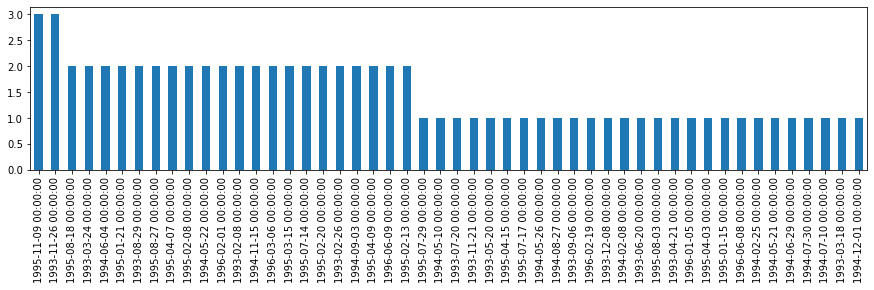

In [30]:
complete['acc date'].value_counts()[:50].plot(kind='bar', figsize=(15,3))

#### Remarks:
The accounts of this dataset were all created between the years 1993 and 1996.

The date of account creation a priori doesn't seem to be related at all with the possible outcome of a loan.

### 1.4.3 Number of transactions - Numerical Attribute

In [31]:
q3, q1 = np.percentile(complete['# trans'], [75 ,25])

print("Min: ", end="");                 print(complete['# trans'].min())
print("Max: ", end="");                 print(complete['# trans'].max())
print("Mean: ", end="");                print(complete['# trans'].mean())
print("Median: ", end="");              print(complete['# trans'].median())
print("Standard deviation: ", end="");  print(complete['# trans'].std())
print("Skewness: ", end="");            print(complete['# trans'].skew())  
print("Variance: ", end="");            print(complete['# trans'].var())
print("Kurtosis: ", end="");            print(complete['# trans'].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 4.0
Max: 191.0
Mean: 71.83582089552239
Median: 65.0
Standard deviation: 44.91376573509647
Skewness: 0.6577715063193036
Variance: 2017.246352507126
Kurtosis: -0.28849786146554823
Interquartile Range: 63.5 | Q1: 35.0 | Q3: 98.5


<AxesSubplot:xlabel='# trans', ylabel='Density'>

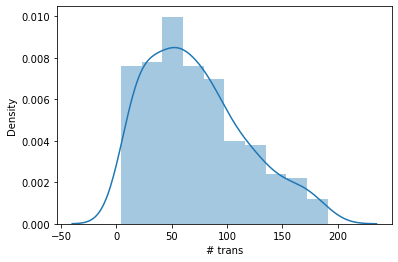

In [32]:
sns.distplot(complete['# trans'])

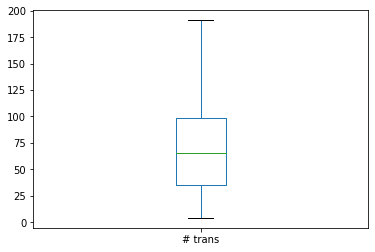

In [33]:
complete['# trans'].plot.box();

#### Remarks:
The number of transactions performed by an account has a very wide range of values and every single one is at minimum 4 and at maximum 196 which justifies the high variance / standard deviation. The majority of the values is concentrated in the range \[39,103\].
By observing the skewness we can classify the data as slightly skewed (between -0.5 and 0.5 would be considered approximately symmetric). The small (in absolute value) kurtosis (it is in the range \[-1,1\]) informs that the distribution is neither too flat or too peeked.

### 1.4.4 Transaction Operations - Numerical Attributes

oper #1    13.283582
oper #2     0.078358
oper #3     3.462687
oper #4     8.623134
oper #5    33.514925
dtype: float64


<AxesSubplot:title={'center':'Average number of transactions per Operation'}>

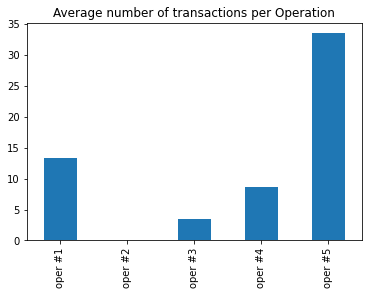

In [34]:
subset = complete[['oper #1', 'oper #2', 'oper #3', 'oper #4', 'oper #5']].mean()
print(subset)
subset.plot(kind='bar', title="Average number of transactions per Operation")

#### Remarks:
The data provided is very unbalanced when it comes to the transaction operations' performed for each account of which there is information about a loan. Of the 5 options identified, 'oper \#5' ('withdrawal in cash') is by far the most common while 'oper \#2' ('credit card withdrawal') is very rare.

Therefore, this attribute might not be of much use to predict the outcome of a loan due to sample size discrepancy of the 5 possible values.

### 1.4.5 Transaction Types - Numerical Attributes

<AxesSubplot:title={'center':'Average number of transactions per Type'}>

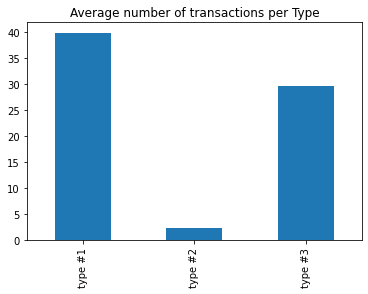

In [35]:
subset = complete[['type #1', 'type #2', 'type #3']].mean()
subset.plot(kind='bar', title="Average number of transactions per Type")

#### Remarks: 
Similar to columns 'oper X' with the difference that in this case only one value is much less represented than the others
Therefore, similarly to the previous attribute, this one might also not be of much use to predict the outcome of a loan due to sample size of 1 of the possible values.

### 1.4.6 Average Transaction Amount - Numerical Attribute

In [36]:
q3, q1 = np.percentile(complete['avg trans amount'], [75 ,25])

print("Min: ", end="");                 print(complete['avg trans amount'].min())
print("Max: ", end="");                 print(complete['avg trans amount'].max())
print("Mean: ", end="");                print(complete['avg trans amount'].mean())
print("Median: ", end="");              print(complete['avg trans amount'].median())
print("Standard deviation: ", end="");  print(complete['avg trans amount'].std())
print("Skewness: ", end="");            print(complete['avg trans amount'].skew())  
print("Variance: ", end="");            print(complete['avg trans amount'].var())
print("Kurtosis: ", end="");            print(complete['avg trans amount'].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

# var() method returns the unbiased variance
# Medium-High std which indicates that the data is spread out and not clustered around the mean
# Skewness > 1 => it is skewed to the right

Min: 2434.24
Max: 24948.66
Mean: 9661.767611940299
Median: 9025.474999999999
Standard deviation: 4233.222091191659
Skewness: 0.49791716768475813
Variance: 17920169.273353085
Kurtosis: -0.03668603604660747
Interquartile Range: 6401.640000000002 | Q1: 6435.7525 | Q3: 12837.392500000002


<AxesSubplot:xlabel='avg trans amount', ylabel='Density'>

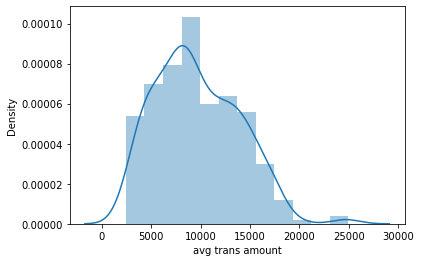

In [37]:
sns.distplot(complete['avg trans amount'])

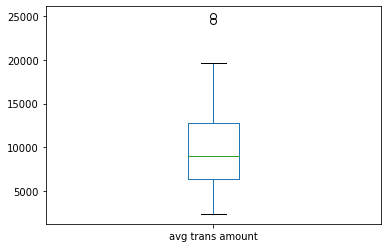

In [38]:
complete['avg trans amount'].plot.box();

#### Remarks:
The 'average transaction amount' atribute seems to follow approximately a normal distribution based on its graphical representation and skewness/kurtosis values.

Despite this, it is possible to identify some values outside the general landscape that can either correspond to outliers or to a real group that is not well represented in the provided data.

### 1.4.7 Average Transaction Balance - Numerical Attribute

In [39]:
q3, q1 = np.percentile(complete['avg trans balance'], [75 ,25])

print("Min: ", end="");                 print(complete['avg trans balance'].min())
print("Max: ", end="");                 print(complete['avg trans balance'].max())
print("Mean: ", end="");                print(complete['avg trans balance'].mean())
print("Median: ", end="");              print(complete['avg trans balance'].median())
print("Standard deviation: ", end="");  print(complete['avg trans balance'].std())
print("Skewness: ", end="");            print(complete['avg trans balance'].skew())  
print("Variance: ", end="");            print(complete['avg trans balance'].var())
print("Kurtosis: ", end="");            print(complete['avg trans balance'].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

# var() method returns the unbiased variance
# Medium-High std which indicates that the data is spread out and not clustered around the mean
# Skewness > 1 => it is skewed to the right

Min: 12250.0
Max: 76232.7
Mean: 43606.68507462686
Median: 42577.325
Standard deviation: 13389.77268170962
Skewness: 0.24689434311522607
Variance: 179286012.46785724
Kurtosis: -0.6556087938166897
Interquartile Range: 20917.055000000008 | Q1: 32633.307499999995 | Q3: 53550.3625


<AxesSubplot:xlabel='avg trans balance', ylabel='Density'>

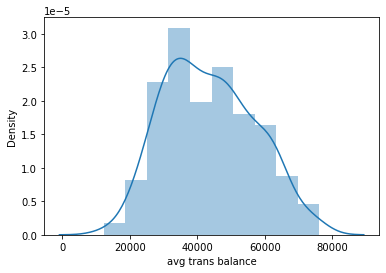

In [40]:
sns.distplot(complete['avg trans balance'])

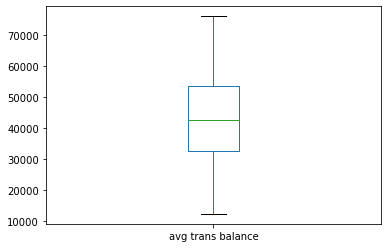

In [41]:
complete['avg trans balance'].plot.box();

#### Remarks:
Like the previous atribute, the 'average transaction balance' seems to follow approximately a normal distribution based on its graphical representation and skewness/kurtosis values. Contrasting with the last atribute, there seem to be no possible outliers, constituting possibly a good candidate variable to predict the outcome of a loan.

### 1.4.8 Loan Date - Date Attribute

In [42]:
complete['loan date'].describe()

count                     268
unique                    237
top       1996-04-29 00:00:00
freq                        3
first     1993-07-05 00:00:00
last      1996-12-27 00:00:00
Name: loan date, dtype: object

In [43]:
print("Min: ", end="");                 print(complete['loan date'].min())
print("Max: ", end="");                 print(complete['loan date'].max())

Min: 1993-07-05 00:00:00
Max: 1996-12-27 00:00:00


<AxesSubplot:>

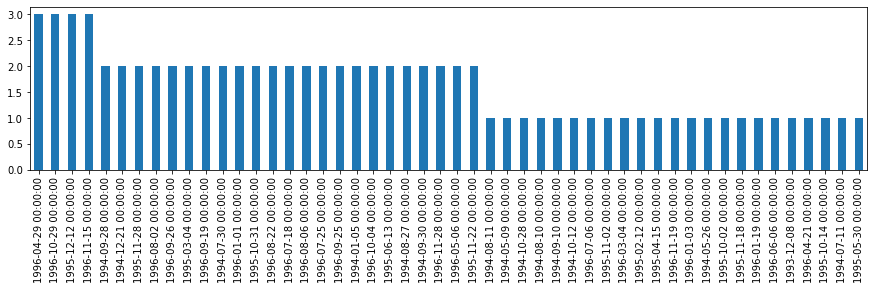

In [44]:
complete['loan date'].value_counts()[:50].plot(kind='bar', figsize=(15,3))

#### Remarks:
The loan of this dataset all date between the years 1993 and 1996, similarly to the account creation dates.

The date of a loan, a priori, doesn't seem to be related at all with the possible outcome of a loan.

In [45]:
q3, q1 = np.percentile(complete['age_at_loan'], [75 ,25])

print("Min: ", end="");                 print(complete['age_at_loan'].min())
print("Max: ", end="");                 print(complete['age_at_loan'].max())
print("Mean: ", end="");                print(complete['age_at_loan'].mean())
print("Median: ", end="");              print(complete['age_at_loan'].median())
print("Standard deviation: ", end="");  print(complete['age_at_loan'].std())
print("Skewness: ", end="");            print(complete['age_at_loan'].skew())  
print("Variance: ", end="");            print(complete['age_at_loan'].var())
print("Kurtosis: ", end="");            print(complete['age_at_loan'].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 13.574264202600958
Max: 60.815879534565376
Mean: 36.678772462124684
Median: 36.087611225188226
Standard deviation: 12.530438478497352
Skewness: 0.09327158875192999
Variance: 157.01188846340702
Kurtosis: -1.120066468418806
Interquartile Range: 21.24435318275154 | Q1: 25.507871321013006 | Q3: 46.752224503764545


In [46]:
ages_distribution = complete.loc[complete['age_at_loan'] < 17]
#print(ages_distribution.shape[0])
print(complete.shape[0])
ages_distribution

#sns.distplot(complete['age_at_loan'])

#complete['age_at_loan'].hist(bins=20)

#fig, ax = plt.subplots()
#fig.set_size_inches(10,8)
#sns.histplot(complete['age_at_loan'], ax=ax)  # distplot is deprecate and replaced by histplot
#ax.set_xlim(15,70)
#ax.set_xticks(range(13,70, 1))
#plt.show()

#complete['age_at_loan'].hist()

268


loan status         frequency   acc date  # trans  oper #1  oper #2  \
loan_id                                                                        
5593              -1  monthly issuance 1994-05-26    117.0     26.0      0.0   
6019               1  monthly issuance 1995-08-03     77.0     18.0      0.0   
7104               1  monthly issuance 1993-07-11     17.0      1.0      0.0   
5449               1  monthly issuance 1994-12-09     52.0     14.0      0.0   
7271               1  monthly issuance 1994-11-24    143.0      2.0      0.0   
6698               1   weekly issuance 1995-08-08     50.0     11.0      0.0   
5385               1  monthly issuance 1996-01-13     31.0      9.0      0.0   
6403               1  monthly issuance 1994-06-01    113.0      1.0      0.0   
5938               1  monthly issuance 1995-10-15     54.0     20.0      0.0   
6687               1  monthly issuance 1993-05-12     17.0      2.0      0.0   
6153               1   weekly issuance 1994-11-15     49.0     17.0      0.0   

         oper #3  oper #4  oper #5  type #1  type #2  type #3  \
loan_id                                                         
5593         0.0      0.0     71.0     70.0      1.0     46.0   
6019         0.0     23.0     25.0     48.0      0.0     29.0   
7104         5.0      1.0      6.0      7.0      0.0     10.0   
5449         0.0      6.0     22.0     28.0      0.0     24.0   
7271        22.0     18.0     79.0     88.0      9.0     46.0   
6698         0.0      6.0     21.0     25.0      2.0     23.0   
5385         0.0      3.0     12.0     15.0      0.0     16.0   
6403        18.0     14.0     62.0     71.0      5.0     37.0   
5938         0.0     11.0     14.0     25.0      0.0     29.0   
6687         4.0      0.0      3.0      3.0      0.0     14.0   
6153         0.0      0.0     25.0     18.0      7.0     24.0   

         avg trans amount  avg trans balance  loan date  loan amount  \
loan_id                                                                
5593             10720.31           46487.00 1996-04-18       277884   
6019              2434.24           27533.66 1996-07-25        11400   
7104             13038.09           45198.15 1993-12-13       259740   
5449              4348.37           27019.57 1995-11-04        99336   
7271             12882.52           57131.74 1996-10-02       392460   
6698             12112.08           60054.73 1996-03-10       247728   
5385             10132.92           49220.98 1996-09-09        71460   
6403              8187.95           36421.43 1995-12-05       194880   
5938              3029.89           21568.94 1996-08-25       402000   
6687              9496.93           46318.55 1993-09-13        87840   
6153             10411.72           49651.89 1995-07-25       285600   

         loan duration (mths)  loan payments  no. of inhabitants  \
loan_id                                                            
5593                       36           7719              105606   
6019                       12            950              387570   
7104                       60           4329              228848   
5449                       24           4139              228848   
7271                       60           6541              107870   
6698                       48           5161             1204953   
5385                       36           1985             1204953   
6403                       48           4060              323870   
5938                       60           6700              149893   
6687                       24           3660               53921   
6153                       60           4760               95616   

         no. of municipalities with inhabitants < 499   \
loan_id                                                  
5593                                                77   
6019                                                 0   
7104                                                15   
5449      

<AxesSubplot:>

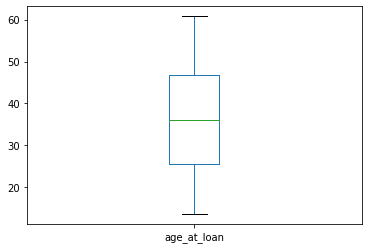

In [47]:
complete['age_at_loan'].plot.box()

#### Remarks:
The range of ages of the clients at the time at which the loan was provided is quite comprehensive.
The skewness indicates a distribution of the data that isn't skewed and the kurtosis points to its flatness, as it is possible to confirm by observation of the distplot.

Despite this aparent 'normality' and, by extent, possibly usefulness of this atribute it is also possible to detect that some values and under the minimum adult age (18 years) which would make these entries invalid and, therefore, creating the necessity to remove them before further analysis.

### 1.4.9 Loan Amount - Numerical Attribute

In [48]:
q3, q1 = np.percentile(complete['loan amount'], [75 ,25])

print("Min: ", end="");                 print(complete['loan amount'].min())
print("Max: ", end="");                 print(complete['loan amount'].max())
print("Mean: ", end="");                print(complete['loan amount'].mean())
print("Median: ", end="");              print(complete['loan amount'].median())
print("Standard deviation: ", end="");  print(complete['loan amount'].std())
print("Skewness: ", end="");            print(complete['loan amount'].skew())  
print("Variance: ", end="");            print(complete['loan amount'].var())
print("Kurtosis: ", end="");            print(complete['loan amount'].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

# Very High std which indicates that the data is spread out and not clustered around the mean
# > 1 therefore it is skewed to the right

Min: 4980
Max: 538500
Mean: 148953.08955223882
Median: 123504.0
Standard deviation: 108130.39773229706
Skewness: 1.0294825896036541
Variance: 11692182913.744753
Kurtosis: 0.6461010529120799
Interquartile Range: 132669.0 | Q1: 68760.0 | Q3: 201429.0


<AxesSubplot:xlabel='loan amount', ylabel='Density'>

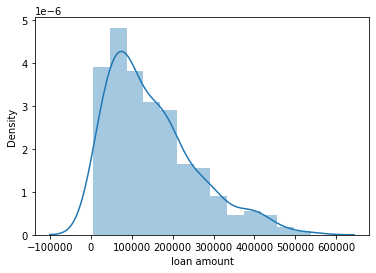

In [49]:
sns.distplot(complete['loan amount'])

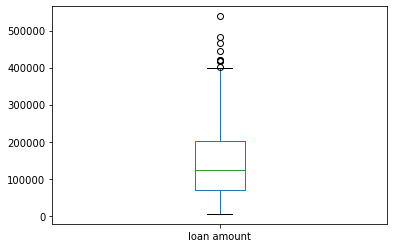

In [50]:
complete['loan amount'].plot.box();

#### Remarks:
The loan amount column data is made of very different values and it is skewed to the right which is confirmed by the skewness. The kurtosis can be confirmed by observation of the seaborn distplot that shows a peak around the value 100000.

It is possible to identify some values outside the general landscape that can either correspond to outliers or to a real group that is not well represented in the provided data. Due to the number of these values we assume the second hypotesis.

### 1.4.10 Loan Duration (in months) - Numerical Attribute

In [51]:
q3, q1 = np.percentile(complete['loan duration (mths)'], [75 ,25])

print("Min: ", end="");                 print(complete['loan duration (mths)'].min())
print("Max: ", end="");                 print(complete['loan duration (mths)'].max())
print("Mean: ", end="");                print(complete['loan duration (mths)'].mean())
print("Median: ", end="");              print(complete['loan duration (mths)'].median())
print("Standard deviation: ", end="");  print(complete['loan duration (mths)'].std())
print("Skewness: ", end="");            print(complete['loan duration (mths)'].skew())  
print("Variance: ", end="");            print(complete['loan duration (mths)'].var())
print("Kurtosis: ", end="");            print(complete['loan duration (mths)'].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 12
Max: 60
Mean: 36.71641791044776
Median: 36.0
Standard deviation: 16.306801935627
Skewness: 0.017498448886337104
Variance: 265.9117893677685
Kurtosis: -1.2269719321679962
Interquartile Range: 24.0 | Q1: 24.0 | Q3: 48.0


<AxesSubplot:>

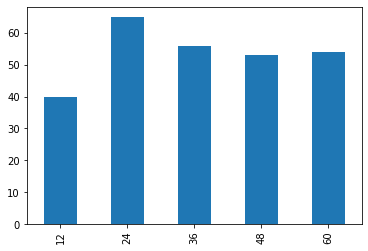

In [52]:
complete['loan duration (mths)'].value_counts().sort_index().plot(kind='bar')

#### Remarks:
In general, the loan duration data seems rather uniform visually, which is in agreement with the statistical analysis results: small absolute value of skewness points to a approximately normal distribution and the lower than -1 kurtosis represents a flat distribution.

Due to the very small variation in frequency of each of the values of this loan duration column, it is plausible to think it won't provide much information regarding the prediction of the outcome of a loan.

### 1.4.11 Loan Payments - Numerical Attribute

In [53]:
q3, q1 = np.percentile(complete['loan payments'], [75 ,25])

print("Min: ", end="");                 print(complete['loan payments'].min())
print("Max: ", end="");                 print(complete['loan payments'].max())
print("Mean: ", end="");                print(complete['loan payments'].mean())
print("Median: ", end="");              print(complete['loan payments'].median())
print("Standard deviation: ", end="");  print(complete['loan payments'].std())
print("Skewness: ", end="");            print(complete['loan payments'].skew())  
print("Variance: ", end="");            print(complete['loan payments'].var())
print("Kurtosis: ", end="");            print(complete['loan payments'].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 319
Max: 9689
Mean: 4095.723880597015
Median: 3802.5
Standard deviation: 2205.2038433868775
Skewness: 0.2968180479666352
Variance: 4862923.990888256
Kurtosis: -0.7952700919998583
Interquartile Range: 3620.0 | Q1: 2268.75 | Q3: 5888.75


<AxesSubplot:xlabel='loan payments', ylabel='Density'>

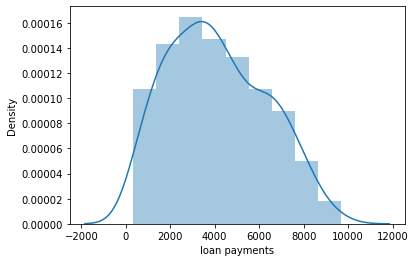

In [54]:
sns.distplot(complete['loan payments'])

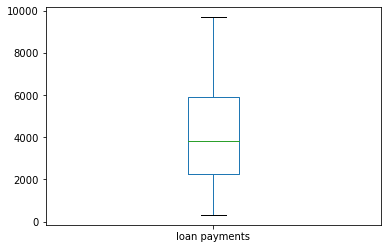

In [55]:
complete['loan payments'].plot.box();

#### Remarks:
Similarly to some of the previous atributes, loan payments follows approximately a normal distribution.
Besides, in some way seems to be in agreement with the loan amount atribute, as expected.

In [56]:
loan_duration_payments = complete[['loan duration (mths)', 'loan payments']].groupby('loan duration (mths)')

temp_df = pd.DataFrame(loan_duration_payments.size())
temp_df['mean'] = loan_duration_payments.mean()
temp_df['min'] = loan_duration_payments.min()
temp_df['max'] = loan_duration_payments.max()

temp_df = temp_df[['mean','min','max']]
temp_df

mean  min   max
loan duration (mths)                        
12                    4192.875000  415  8734
24                    4111.676923  319  8260
36                    4266.196429  529  8308
48                    3984.905660  424  9689
60                    3936.537037  501  8975

### 1.4.12 Loan Status - Binominal Attribute

In [57]:
complete['loan status'].describe()

count    268.000000
mean       0.723881
std        0.691216
min       -1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: loan status, dtype: float64

<AxesSubplot:title={'center':'Loan Status Distribution'}>

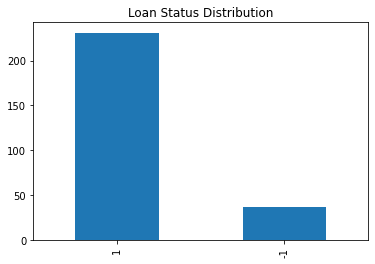

In [58]:
# -1 -> not paid; 1 -> paid
complete['loan status'].value_counts().plot(kind='bar', title="Loan Status Distribution")

#### Remarks:
By observation alone it is clear that the amount of loans where an account fulfills its commitments to the bank severely surpasses the number of entries where default credit it the result. Then, oversampling/undersampling methods might useful.

### 1.4.13 Number of district inhabitants - Numerical Attribute

In [59]:
q3, q1 = np.percentile(complete['no. of inhabitants'], [75 ,25])

print("Min: ", end="");                 print(complete['no. of inhabitants'].min())
print("Max: ", end="");                 print(complete['no. of inhabitants'].max())
print("Mean: ", end="");                print(complete['no. of inhabitants'].mean())
print("Median: ", end="");              print(complete['no. of inhabitants'].median())
print("Standard deviation: ", end="");  print(complete['no. of inhabitants'].std())
print("Skewness: ", end="");            print(complete['no. of inhabitants'].skew())  
print("Variance: ", end="");            print(complete['no. of inhabitants'].var())
print("Kurtosis: ", end="");            print(complete['no. of inhabitants'].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 42821
Max: 1204953
Mean: 276219.62313432834
Median: 124920.5
Standard deviation: 362949.5265839029
Skewness: 2.0679763718607815
Variance: 131732358847.47925
Kurtosis: 2.5935478161592256
Interquartile Range: 134838.0 | Q1: 91284.0 | Q3: 226122.0


<AxesSubplot:xlabel='no. of inhabitants', ylabel='Density'>

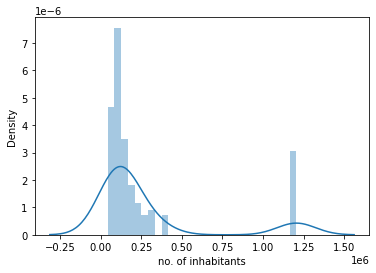

In [60]:
sns.distplot(complete['no. of inhabitants'])

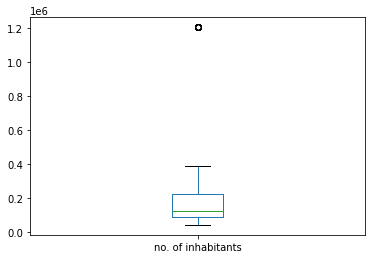

In [61]:
complete['no. of inhabitants'].plot.box();

#### Remarks:
Without the data past 750 thousand inhabitants, the atribute would assume almost a perfect normal distribution. As is, the data distribution is substantially skewed and the kurtosis confirms the peaked characterization.
Due to the percentage of information that fits in the supposed 'outlier zone', these entries can't be considered outliers. They may just represent a densely populated area where the average corresponds to semi-urban or even rural regions and the provided data simply doesn't have information regarding regions whose population numbers fit the \[400000, 1100000\] range.

### 1.4.14 Inahbitants per municipality - Numerical Attribute

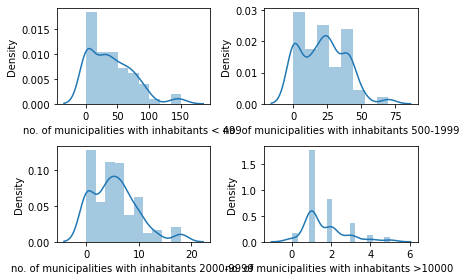

In [62]:
fig, ax = plt.subplots(2,2)
sns.distplot(complete['no. of municipalities with inhabitants < 499 '], ax=ax[0][0])
sns.distplot(complete['no. of municipalities with inhabitants 500-1999'], ax=ax[0][1])

sns.distplot(complete['no. of municipalities with inhabitants 2000-9999 '], ax=ax[1][0])
sns.distplot(complete['no. of municipalities with inhabitants >10000 '], ax=ax[1][1])
fig.tight_layout()
fig.show()

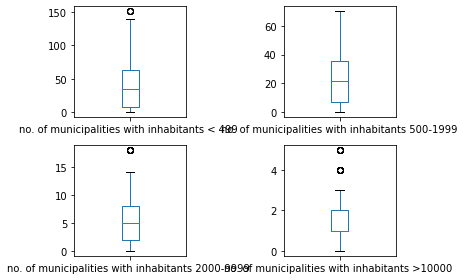

In [63]:
complete[['no. of municipalities with inhabitants < 499 ', 'no. of municipalities with inhabitants 500-1999', 'no. of municipalities with inhabitants 2000-9999 ', 'no. of municipalities with inhabitants >10000 ']].plot(kind='box', subplots=True, legend=False, layout=(2, 2))
plt.tight_layout()

#### Remarks:
The distributions of the number of municipalities seem very disperse and with aparent low value by themselves for loan predictions. Nonetheless, it can be especulated that many of the accounts belong to people that live in a far more densely populated area that the rest, hyposthesis that is corroborated by the previous and next data regarding the districts.

### 1.4.15 Number of cities of district - Numerical Attribute

In [64]:
q3, q1 = np.percentile(complete['no. of cities '], [75 ,25])

print("Min: ", end="");                 print(complete['no. of cities '].min())
print("Max: ", end="");                 print(complete['no. of cities '].max())
print("Mean: ", end="");                print(complete['no. of cities '].mean())
print("Median: ", end="");              print(complete['no. of cities '].median())
print("Standard deviation: ", end="");  print(complete['no. of cities '].std())
print("Skewness: ", end="");            print(complete['no. of cities '].skew())  
print("Variance: ", end="");            print(complete['no. of cities '].var())
print("Kurtosis: ", end="");            print(complete['no. of cities '].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 1
Max: 11
Mean: 5.186567164179104
Median: 5.0
Standard deviation: 2.870925963318776
Skewness: 0.023687574900577414
Variance: 8.242215886857842
Kurtosis: -0.9523297776332447
Interquartile Range: 3.0 | Q1: 4.0 | Q3: 7.0


<AxesSubplot:>

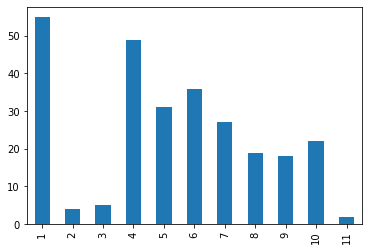

In [65]:
complete['no. of cities '].value_counts().sort_index().plot(kind='bar')

<AxesSubplot:xlabel='no. of cities ', ylabel='Density'>

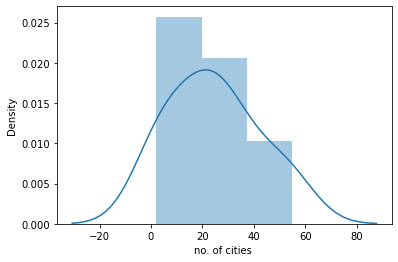

In [66]:
sns.distplot(complete['no. of cities '].value_counts())

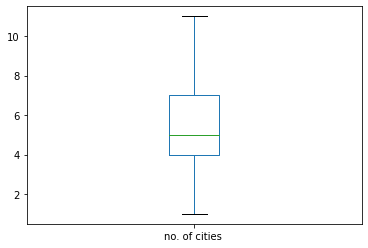

In [67]:
complete['no. of cities '].plot.box();

#### Remarks:
Aproximately a normal distribution.
This data doesn't seem to indicate any anomaly that might skew the outcome of a loan.

### 1.4.16 Ratio of Urban Inhabitants - Numerical Attribute

In [68]:
q3, q1 = np.percentile(complete['ratio of urban inhabitants '], [75 ,25])

print("Min: ", end="");                 print(complete['ratio of urban inhabitants '].min())
print("Max: ", end="");                 print(complete['ratio of urban inhabitants '].max())
print("Mean: ", end="");                print(complete['ratio of urban inhabitants '].mean())
print("Median: ", end="");              print(complete['ratio of urban inhabitants '].median())
print("Standard deviation: ", end="");  print(complete['ratio of urban inhabitants '].std())
print("Skewness: ", end="");            print(complete['ratio of urban inhabitants '].skew())  
print("Variance: ", end="");            print(complete['ratio of urban inhabitants '].var())
print("Kurtosis: ", end="");            print(complete['ratio of urban inhabitants '].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 33.9
Max: 100.0
Mean: 68.36044776119407
Median: 61.9
Standard deviation: 20.582001950566934
Skewness: 0.354191731913288
Variance: 423.61880429314107
Kurtosis: -1.1529557981938778
Interquartile Range: 35.325 | Q1: 52.925 | Q3: 88.25


<AxesSubplot:xlabel='ratio of urban inhabitants ', ylabel='Density'>

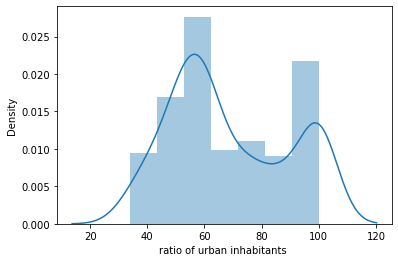

In [69]:
sns.distplot(complete['ratio of urban inhabitants '])

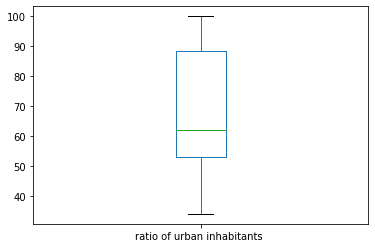

In [70]:
complete['ratio of urban inhabitants '].plot.box();

#### Remarks:
The range of districts' ratio of urban inhabitants is very wide. The provided information regarding people that took loans points to 2 concentrations: in districts where the urban inhabitants constitute either 50 or 100 percent of the population. Due to these 2 spikes, the skewness and kurtosis conclude an approximate normal and flat distribution of the data.

### 1.4.17 Average Salary - Numerical Attribute

In [71]:
q3, q1 = np.percentile(complete['average salary '], [75 ,25])

print("Min: ", end="");                 print(complete['average salary '].min())
print("Max: ", end="");                 print(complete['average salary '].max())
print("Mean: ", end="");                print(complete['average salary '].mean())
print("Median: ", end="");              print(complete['average salary '].median())
print("Standard deviation: ", end="");  print(complete['average salary '].std())
print("Skewness: ", end="");            print(complete['average salary '].skew())  
print("Variance: ", end="");            print(complete['average salary '].var())
print("Kurtosis: ", end="");            print(complete['average salary '].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 8110
Max: 12541
Mean: 9561.014925373134
Median: 8994.0
Standard deviation: 1321.6880279483844
Skewness: 1.2876581072129776
Variance: 1746859.243222089
Kurtosis: 0.576495537367125
Interquartile Range: 1498.0 | Q1: 8547.0 | Q3: 10045.0


<AxesSubplot:>

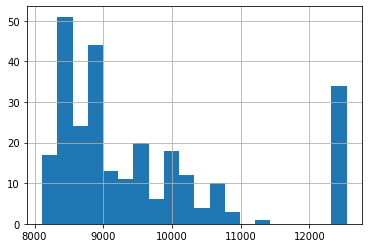

In [72]:
# sns.distplot(complete['average salary '])
complete['average salary '].hist(bins=20)

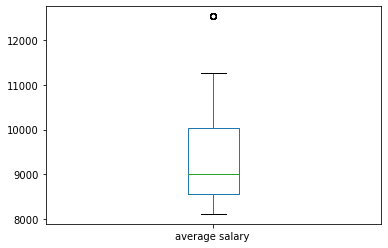

In [73]:
complete['average salary '].plot.box();

#### Remarks:
The average salary atribute seems to follow graphically a distribution somewhat similar to the ratio or urban inhabitants. The second 'spike' in this column could be taken as outlier because it is separated from the rest, which is not an option because of the percentage of the entries that it represents.

### 1.4.18 Unemploymant Rate - Numerical Attribute

In [74]:
#complete.loc[complete["unemploymant rate '95 "] == '?', "unemploymant rate '95 "] = complete["unemploymant rate '96 "]
#complete.loc[complete["unemploymant rate '96 "] == '?', "unemploymant rate '96 "] = complete["unemploymant rate '95 "]

#### Obtain the average of 95' and 96' columns

In [75]:
#complete["unemploymant rate"] = (complete["unemploymant rate '95 "].astype('float') + complete["unemploymant rate '96 "].astype('float')) / 2.0
#complete = complete.drop(columns=["unemploymant rate '95 ", "unemploymant rate '96 "])
# complete

In [76]:
q3, q1 = np.percentile(complete['unemploymant rate'], [75 ,25])

print("Min: ", end="");                 print(complete['unemploymant rate'].min())
print("Max: ", end="");                 print(complete['unemploymant rate'].max())
print("Mean: ", end="");                print(complete['unemploymant rate'].mean())
print("Median: ", end="");              print(complete['unemploymant rate'].median())
print("Standard deviation: ", end="");  print(complete['unemploymant rate'].std())
print("Skewness: ", end="");            print(complete['unemploymant rate'].skew())  
print("Variance: ", end="");            print(complete['unemploymant rate'].var())
print("Kurtosis: ", end="");            print(complete['unemploymant rate'].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 0.36
Max: 8.370000000000001
Mean: 3.222817164179101
Median: 3.03
Standard deviation: 2.0978117259675404
Skewness: 0.5421968777366726
Variance: 4.400814037606911
Kurtosis: -0.3944455172792032
Interquartile Range: 2.7049999999999996 | Q1: 1.6999999999999997 | Q3: 4.404999999999999


<AxesSubplot:xlabel='unemploymant rate', ylabel='Density'>

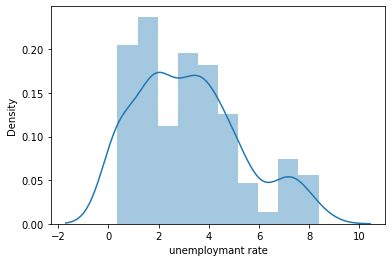

In [77]:
sns.distplot(complete['unemploymant rate'])

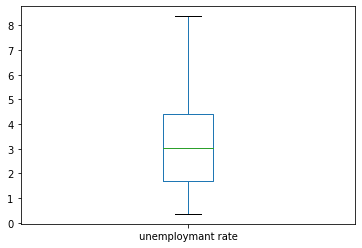

In [78]:
complete['unemploymant rate'].plot.box();

#### Remarks:
The unemploymant rate seems to follow a normal distribution and doesn't have any outliers.

### 1.4.19 Number of enterpreneurs per 1000 inhabitants - Numerical Attribute

In [79]:
q3, q1 = np.percentile(complete['no. of enterpreneurs per 1000 inhabitants '], [75 ,25])

print("Min: ", end="");                 print(complete['no. of enterpreneurs per 1000 inhabitants '].min())
print("Max: ", end="");                 print(complete['no. of enterpreneurs per 1000 inhabitants '].max())
print("Mean: ", end="");                print(complete['no. of enterpreneurs per 1000 inhabitants '].mean())
print("Median: ", end="");              print(complete['no. of enterpreneurs per 1000 inhabitants '].median())
print("Standard deviation: ", end="");  print(complete['no. of enterpreneurs per 1000 inhabitants '].std())
print("Skewness: ", end="");            print(complete['no. of enterpreneurs per 1000 inhabitants '].skew())  
print("Variance: ", end="");            print(complete['no. of enterpreneurs per 1000 inhabitants '].var())
print("Kurtosis: ", end="");            print(complete['no. of enterpreneurs per 1000 inhabitants '].kurtosis())
print("Interquartile Range: ", end=""); print(q3 - q1, end=" | "); print("Q1: {} | Q3: {}".format(q1,q3))

Min: 81
Max: 167
Mean: 121.72388059701493
Median: 114.5
Standard deviation: 23.466572541215527
Skewness: 0.637558350848588
Variance: 550.6800268321306
Kurtosis: -0.49380590400163804
Interquartile Range: 31.0 | Q1: 106.0 | Q3: 137.0


<AxesSubplot:xlabel='no. of enterpreneurs per 1000 inhabitants ', ylabel='Density'>

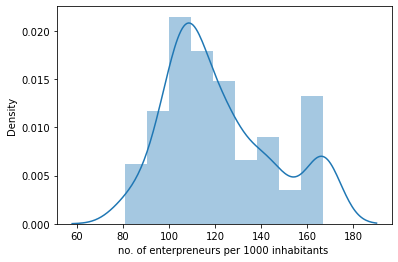

In [80]:
sns.distplot(complete['no. of enterpreneurs per 1000 inhabitants '])

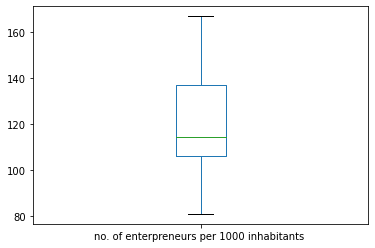

In [81]:
complete['no. of enterpreneurs per 1000 inhabitants '].plot.box();

#### Remarks:
Interestingly, the number of enterpreneurs per 1000 inhabitants follows a distribution practically identical to the ratio of urban inhabitants and average salary, which may represent that some of the columns regarding district data might be redundant.

### 1.4.20 Number of commited crimes per capita - Numerical Attribute

In [82]:
#complete.loc[complete["no. of commited crimes '95 "] == '?', "no. of commited crimes '95 "] = complete["no. of commited crimes '96 "]
#complete.loc[complete["no. of commited crimes '96 "] == '?', "no. of commited crimes '96 "] = complete["no. of commited crimes '95 "]

#### Obtain the average of 95' and 96' columns and then divide by the number of inhabitants

In [83]:
#complete["no. of commited crimes per capita"] = (complete["no. of commited crimes '95 "].astype('float') + complete["no. of commited crimes '96 "].astype('float')) / 2.0 / complete["no. of inhabitants"]
#complete = complete.drop(columns=["no. of commited crimes '95 ", "no. of commited crimes '96 "])
# complete

<AxesSubplot:xlabel='no. of commited crimes per capita', ylabel='Density'>

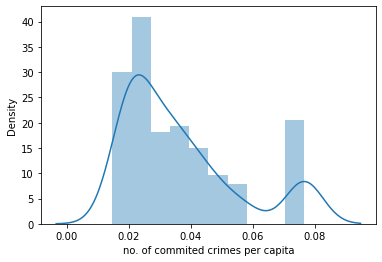

In [84]:
sns.distplot(complete['no. of commited crimes per capita'])

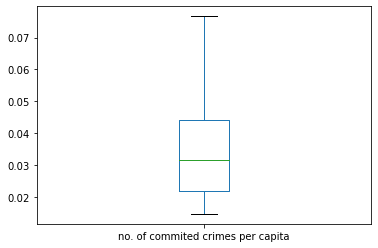

In [85]:
complete['no. of commited crimes per capita'].plot.box();

#### Remarks:
The number of crimes per capita follows the general district data distribution. One peculiarity by 'crossing data' is that the second spike in this case corresponds to places with higher numbers of inhabitants.

### 1.4.21 Card Type - Numerical Attribute

In [86]:
complete['card type'].describe()

count      268
unique       4
top       None
freq       258
Name: card type, dtype: object

<AxesSubplot:>

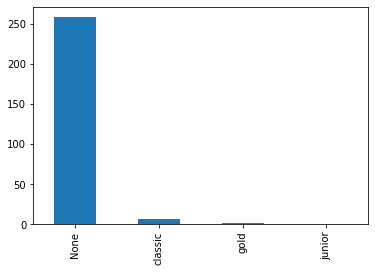

In [87]:
complete['card type'].value_counts().plot(kind='bar')

#### Filling Missing Values with 'None'

In [88]:
#complete['card type'] = complete['card type'].fillna('None')

In [89]:
complete['card type'].value_counts()

None       258
classic      7
gold         2
junior       1
Name: card type, dtype: int64

In [90]:
complete['card type'].unique()

array(['None', 'gold', 'classic', 'junior'], dtype=object)

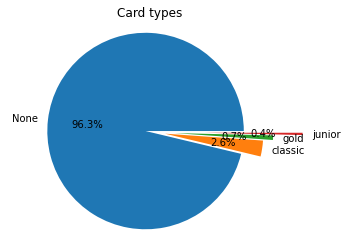

In [91]:
fig, ax = plt.subplots()
ax.pie(complete['card type'].value_counts(), labels=['None', 'classic', 'gold', 'junior'], autopct='%1.1f%%', explode = [0.1,0.1,0.2,0.5])
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Card types             ')

plt.show()

#### Remarks:
Missing values ('NaN') are infered to be 'no card existent' and therefore replaced by 'None' because in the 90s the popularity of the credit was still low.
Despite the very small amount of entries that have card data, this atribute can still be considered useful: for example, to have a card might lead to a higher chance to pay a loan.

In [92]:
card_loan_status = complete[['card type', 'loan status']].groupby('card type')
display(card_loan_status.mean())

loan status
card type             
None          0.713178
classic       1.000000
gold          1.000000
junior        1.000000

#### Remarks:
Interestingly, everyone of the few card holders has paid off the loan.

### 1.4.22 Birthdate - Date Attribute

In [93]:
complete['birthdate'].describe()

count                     268
unique                    258
top       1949-03-08 00:00:00
freq                        2
first     1935-01-29 00:00:00
last      1980-12-07 00:00:00
Name: birthdate, dtype: object

In [94]:
print("Min: ", end="");                 print(complete['birthdate'].min())
print("Max: ", end="");                 print(complete['birthdate'].max())

Min: 1935-01-29 00:00:00
Max: 1980-12-07 00:00:00


<AxesSubplot:>

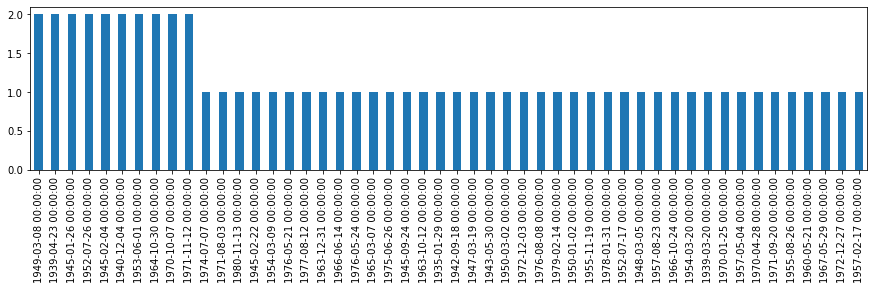

In [95]:
complete['birthdate'].value_counts()[:50].plot(kind='bar', figsize=(15,3))

#### Remarks:
The birthdate of an account owner, a priori, doesn't seem to be related at all with the possible outcome of a loan, but might be useful to detect anomalies like the possibility of an under 18 person to contract a loan which is invalid.

### 1.4.23 Client Sex - Nominal Categorical Attribute

In [96]:
complete['sex'].describe()

count     268
unique      2
top         M
freq      138
Name: sex, dtype: object

<AxesSubplot:>

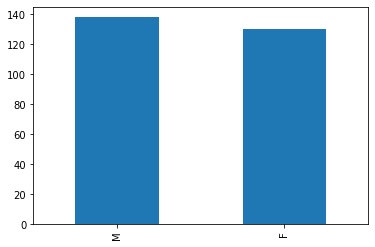

In [97]:
complete['sex'].value_counts().plot(kind='bar')

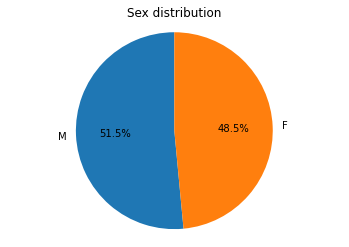

In [98]:
fig, ax = plt.subplots()
ax.pie(complete['sex'].value_counts(), labels=complete['sex'].unique(), autopct='%1.1f%%', startangle = 90)
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Sex distribution')

plt.show()

#### Remarks:
There isn't any unbalance in the total distribution of individuals regarding their sex which should lead to a plausible atribute for loan prediction.

In [99]:
gender_loan_status = complete[['sex', 'loan status']].groupby('sex')
gender_loan_status.mean()

loan status
sex             
F       0.707692
M       0.739130

### 1.4.23 Account has disponent or not - Nominal Categorical Attribute

In [100]:
complete['has disponent'].describe()

count       268
unique        2
top       False
freq        204
Name: has disponent, dtype: object

<AxesSubplot:>

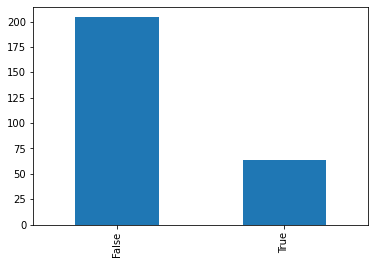

In [101]:
complete['has disponent'].value_counts().plot(kind='bar')

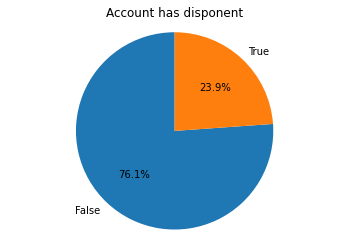

In [102]:
fig, ax = plt.subplots()
ax.pie(complete['has disponent'].value_counts(), labels=complete['has disponent'].unique(), autopct='%1.1f%%', startangle = 90)
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
ax.set_title('Account has disponent')

plt.show()

#### Remarks
Despite the frequency disparity between the two possible values, another person besides the owner associated with an account may imply a higher or lower chance of loan payment.

In [103]:
disponent_loan_amount = complete[['has disponent', 'loan amount']].groupby('has disponent')

print("Mean:")
display(disponent_loan_amount.mean())
print("\nMin:")
display(disponent_loan_amount.min())
print("\nMax:")
display(disponent_loan_amount.max())
print("\nStd Dev:")
display(disponent_loan_amount.std())

Mean:


loan amount
has disponent               
False          145865.411765
True           158795.062500


Min:


loan amount
has disponent             
False                 4980
True                  7656


Max:


loan amount
has disponent             
False               538500
True                465072


Std Dev:


loan amount
has disponent               
False          105287.155010
True           117062.964436

In [104]:
disponent_loan_status = complete[['has disponent', 'loan status']].groupby('has disponent')
display(disponent_loan_amount.mean())

loan amount
has disponent               
False          145865.411765
True           158795.062500

In [105]:
#complete.to_csv("./complete_data_comp_final_1.csv", sep=";")

In [106]:
#complete.loc[complete['age at loan (Years)'] < 18]

In [107]:
complete.columns

Index(['loan status', 'frequency', 'acc date', '# trans', 'oper #1', 'oper #2',
       'oper #3', 'oper #4', 'oper #5', 'type #1', 'type #2', 'type #3',
       'avg trans amount', 'avg trans balance', 'loan date', 'loan amount',
       'loan duration (mths)', 'loan payments', 'no. of inhabitants',
       'no. of municipalities with inhabitants < 499 ',
       'no. of municipalities with inhabitants 500-1999',
       'no. of municipalities with inhabitants 2000-9999 ',
       'no. of municipalities with inhabitants >10000 ', 'no. of cities ',
       'ratio of urban inhabitants ', 'average salary ',
       'no. of enterpreneurs per 1000 inhabitants ', 'card type', 'birthdate',
       'sex', 'has disponent', 'age_at_loan', 'acc_age_at_loan',
       'unemploymant rate', 'no. of commited crimes per capita',
       'district_id'],
      dtype='object')

In [108]:
complete['birthdate']

loan_id
6077   1970-04-28
6103   1963-02-01
5593   1980-09-17
7227   1955-11-18
7284   1973-02-16
          ...    
5892   1935-07-21
6015   1963-10-12
5606   1945-08-07
7246   1977-08-03
6751   1938-05-03
Name: birthdate, Length: 268, dtype: datetime64[ns]

## 1.5 Multivariate Data Analysis

In [109]:
pre_dummy = complete.drop(columns=['acc date', 'loan date', 'birthdate', 'district_id'])
pre_dummy.columns

Index(['loan status', 'frequency', '# trans', 'oper #1', 'oper #2', 'oper #3',
       'oper #4', 'oper #5', 'type #1', 'type #2', 'type #3',
       'avg trans amount', 'avg trans balance', 'loan amount',
       'loan duration (mths)', 'loan payments', 'no. of inhabitants',
       'no. of municipalities with inhabitants < 499 ',
       'no. of municipalities with inhabitants 500-1999',
       'no. of municipalities with inhabitants 2000-9999 ',
       'no. of municipalities with inhabitants >10000 ', 'no. of cities ',
       'ratio of urban inhabitants ', 'average salary ',
       'no. of enterpreneurs per 1000 inhabitants ', 'card type', 'sex',
       'has disponent', 'age_at_loan', 'acc_age_at_loan', 'unemploymant rate',
       'no. of commited crimes per capita'],
      dtype='object')

### Regression

In [110]:
df_dummy = pd.get_dummies(pre_dummy)
df_dummy_2 = pd.get_dummies(complete['loan status'])
df_dummy = pd.concat([df_dummy_2, df_dummy], axis=1)
df_dummy.drop(['loan status', 'sex_F', 1], inplace = True, axis = 1)
df_dummy.rename(columns = {-1: "not_paid", '# trans': "#_trans", 'loan amount': 'loan_amount', 'average salary ': 'avg_sal', 'unemploymant rate': 'unemploymant_rate'}, inplace = True)
df_dummy = df_dummy.drop(columns=['oper #1','oper #2','oper #3','oper #4','oper #5','type #1','type #2','type #3','avg trans amount', 'avg trans balance','no. of enterpreneurs per 1000 inhabitants ', 'no. of inhabitants','no. of municipalities with inhabitants < 499 ','no. of municipalities with inhabitants 500-1999', 'no. of municipalities with inhabitants 2000-9999 ', 'no. of municipalities with inhabitants >10000 ', 'no. of cities ','ratio of urban inhabitants ', 'has disponent'])
df_dummy

not_paid  #_trans  loan_amount  loan duration (mths)  loan payments  \
loan_id                                                                        
6077            0     53.0        79608                    24           3317   
6103            0     56.0       149340                    60           2489   
5593            1    117.0       277884                    36           7719   
7227            0    130.0       314520                    60           5242   
7284            0     43.0        52788                    12           4399   
...           ...      ...          ...                   ...            ...   
5892            1     10.0        66480                    24           2770   
6015            0     82.0       110112                    24           4588   
5606            1     29.0       253512                    36           7042   
7246            0     31.0       148920                    60           2482   
6751            0     19.0        85716                    36           2381   

         avg_sal  age_at_loan  acc_age_at_loan  unemploymant_rate  \
loan_id                                                             
6077        8254    23.570157         0.856947              3.275   
6103        8254    31.178645         0.878850              3.275   
5593        8254    15.583847         1.897331              3.275   
7227        8254    39.871321         1.325120              3.275   
7284        9045    20.577687         0.668036              3.365   
...          ...          ...              ...                ...   
5892        8746    60.815880         0.380561              3.535   
6015        8240    33.078713         0.903491              3.045   
5606        8444    51.058179         0.583162              3.355   
7246        8444    19.047228         0.550308              3.355   
6751        8114    58.198494         0.418891              2.500   

         no. of commited crimes per capita  \
loan_id                                      
6077                              0.021263   
6103                              0.021263   
5593                              0.021263   
7227                              0.021263   
7284                              0.031669   
...                                    ...   
5892                              0.024139   
6015                              0.017389   
5606                              0.022504   
7246                              0.022504   
6751                              0.014744   

         frequency_issuance after transaction  frequency_monthly issuance  \
loan_id                                                                     
6077                                        0                           1   
6103                                        0                           0   
5593                                        0                           1   
7227                                        0                           0   
7284                                        0                           1   
...                                       ...                         ...   
5892                                        0                           0   
6015                                        0                           1   
5606                                        0                           0   
7246                                        0                           0   
6751                                        0                           1   

         frequency_weekly issuance  card type_None  card type_classic  \
loan_id                                                                 
6077                             0               1                  0   
6103                             1               1                  0   
5593                             0               1                  0   
7227                             1               1                  0   
7284                           

In [111]:
from statsmodels.formula.api import ols
from scipy import stats
import statsmodels.api as sm

reg = sm.OLS(df_dummy["not_paid"], sm.add_constant(df_dummy[['#_trans', 'loan_amount', 'loan duration (mths)', 'loan payments', 'avg_sal', 'age_at_loan', 'acc_age_at_loan', 'unemploymant_rate', 'no. of commited crimes per capita', 'frequency_issuance after transaction', 'frequency_monthly issuance', 'frequency_weekly issuance', 'card type_None', 'card type_classic', 'card type_gold', 'card type_junior', 'sex_M']])).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:               not_paid   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     1.057
Date:                Tue, 21 Dec 2021   Prob (F-statistic):              0.398
Time:                        17:22:46   Log-Likelihood:                -86.863
No. Observations:                 268   AIC:                             205.7
Df Residuals:                     252   BIC:                             263.2
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


#### Remarks:
By applying OLS (Ordinary least squares) we can see that Linear Regression isn't the appropriate model for predictions down the line. The p-values are all well above the 0.05 threshold (and therefore, 'insignificant') and the R-squared (proportion of the variance for the dependent variable that is explained by independent variables) is very close to 0 which indicates that the explanatory power of the Linear Regression is basically nulls.

In [112]:
df_num = complete.select_dtypes(include = ['float64', 'int64'])
df_num.columns

Index(['loan status', '# trans', 'oper #1', 'oper #2', 'oper #3', 'oper #4',
       'oper #5', 'type #1', 'type #2', 'type #3', 'avg trans amount',
       'avg trans balance', 'loan amount', 'loan duration (mths)',
       'loan payments', 'no. of inhabitants',
       'no. of municipalities with inhabitants < 499 ',
       'no. of municipalities with inhabitants 500-1999',
       'no. of municipalities with inhabitants 2000-9999 ',
       'no. of municipalities with inhabitants >10000 ', 'no. of cities ',
       'ratio of urban inhabitants ', 'average salary ',
       'no. of enterpreneurs per 1000 inhabitants ', 'age_at_loan',
       'acc_age_at_loan', 'unemploymant rate',
       'no. of commited crimes per capita', 'district_id'],
      dtype='object')

### 1.5.1 Covariance Matrix

<AxesSubplot:>

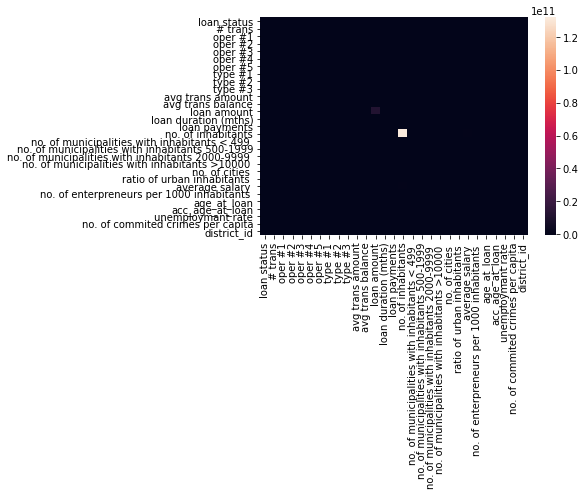

In [113]:
# plot the heatmap
sns.heatmap(df_num.cov(), 
        xticklabels=df_num.columns,
        yticklabels=df_num.columns)

### 1.5.2 Correlation Matrix

#### 1.5.2.1 Pearson (standard correlation coefficient)

In [114]:
pearsoncorr = df_num.drop(columns=['district_id']).corr(method='pearson').round(2)
pearsoncorr

loan status  # trans  \
loan status                                               1.00     0.10   
# trans                                                   0.10     1.00   
oper #1                                                  -0.03     0.63   
oper #2                                                   0.05     0.14   
oper #3                                                   0.14     0.20   
oper #4                                                   0.19     0.67   
oper #5                                                   0.08     0.95   
type #1                                                   0.14     0.97   
type #2                                                   0.05     0.53   
type #3                                                   0.02     0.93   
avg trans amount                                          0.06    -0.09   
avg trans balance                                         0.22     0.16   
loan amount                                              -0.09     0.09   
loan duration (mths)                                      0.05     0.10   
loan payments                                            -0.17    -0.00   
no. of inhabitants                                       -0.01    -0.01   
no. of municipalities with inhabitants < 499              0.09     0.10   
no. of municipalities with inhabitants 500-1999           0.08    -0.01   
no. of municipalities with inhabitants 2000-9999          0.01    -0.05   
no. of municipalities with inhabitants >10000             0.06    -0.05   
no. of cities                                             0.05     0.11   
ratio of urban inhabitants                               -0.02     0.02   
average salary                                            0.02    -0.04   
no. of enterpreneurs per 1000 inhabitants                 0.02     0.04   
age_at_loan                                              -0.04    -0.03   
acc_age_at_loan                                           0.09     0.91   
unemploymant rate                                         0.02    -0.03   
no. of commited crimes per capita                        -0.01    -0.02   

                                                   oper #1  oper #2  oper #3  \
loan status                                          -0.03     0.05     0.14   
# trans                                               0.63     0.14     0.20   
oper #1                                               1.00     0.06    -0.55   
oper #2                                               0.06     1.00     0.00   
oper #3                                              -0.55     0.00     1.00   
oper #4                                               0.28     0.19     0.11   
oper #5                                               0.59     0.09     0.26   
type #1                                               0.55     0.18     0.21   
type #2                                               0.30     0.01     0.34   
type #3                                               0.72     0.07     0.10   
avg trans amount                                     -0.07    -0.03     0.17   
avg trans balance                                     0.14     0.01     0.11   
loan amount                                           0.09    -0.02     0.06   
loan duration (mths)                                  0.15     0.06    -0.07   
loan payments                                        -0.03    -0.06     0.11   
no. of inhabitants                                    0.02    -0.04    -0.05   
no. of municipalities with inhabitants < 499          0.04     0.04     0.09   
no. of municipalities with inhabitants 500-1999      -0.01     0.05     0.01   
no. of municipalities with inhabitants 2000-9999     -0.05     0.09     0.01   
no. of municipalities with inhabitants >10000        -0.06    -0.13    -0.00   
no. of cities                                         0.07     0.05     0.04   
ratio of urban inhabitants                            0.07    -0.08    -0.08   
average salary                     

<AxesSubplot:>

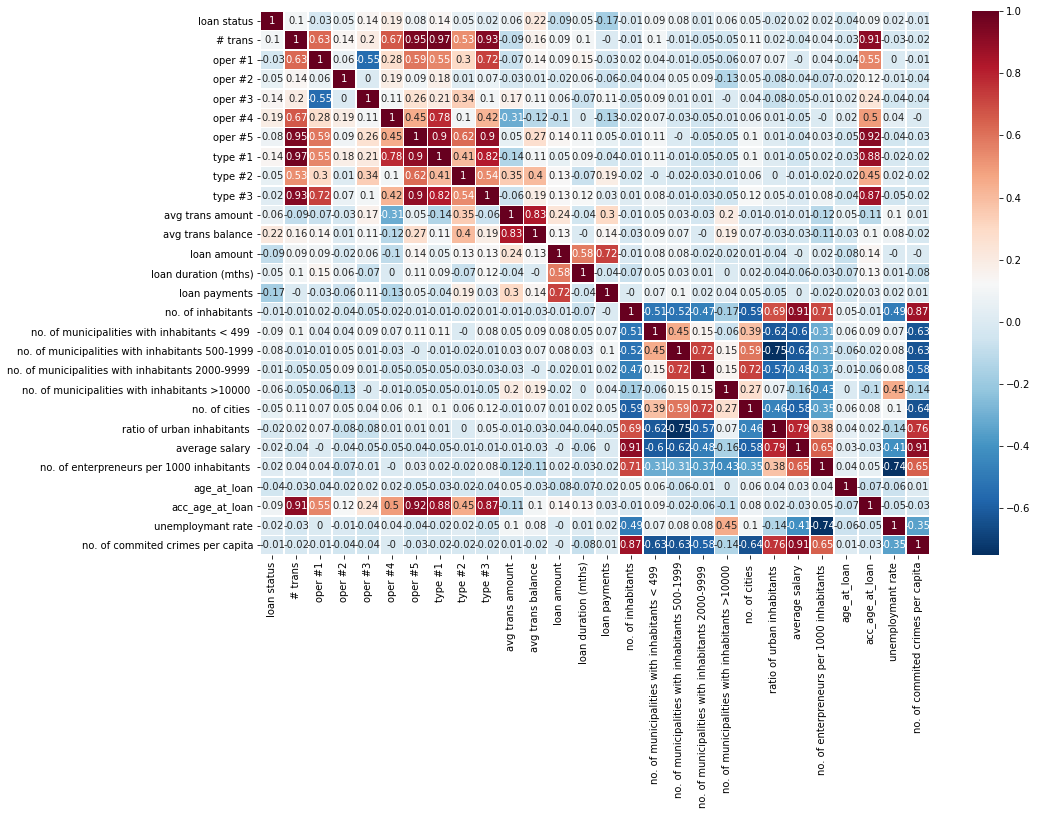

In [115]:
fig, ax = plt.subplots(figsize=(15,10)) 
sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            linewidth=0.5,
            annot=True,
            ax=ax)

In [116]:
complete['loan status'].corr(complete['average salary '])

0.02385624670284942

In [117]:
from scipy import stats

In [118]:
r, p = stats.pearsonr(complete['loan status'], complete['average salary '])
print(round(r, 4))
print(round(p, 4))

0.0239
0.6974


In [119]:
corr_df = pd.DataFrame(columns=['r', 'p'])

for col in complete:
    if pd.api.types.is_numeric_dtype(complete[col]) and col != 'loan status':
        r, p = stats.pearsonr(complete['loan status'], complete[col])
        corr_df.loc[col] = [round(r, 3), round(p, 3)]
    
corr_df

r      p
# trans                                            0.104  0.089
oper #1                                           -0.032  0.604
oper #2                                            0.049  0.423
oper #3                                            0.142  0.020
oper #4                                            0.185  0.002
oper #5                                            0.081  0.184
type #1                                            0.140  0.022
type #2                                            0.053  0.390
type #3                                            0.024  0.694
avg trans amount                                   0.063  0.302
avg trans balance                                  0.223  0.000
loan amount                                       -0.092  0.131
loan duration (mths)                               0.050  0.419
loan payments                                     -0.167  0.006
no. of inhabitants                                -0.010  0.874
no. of municipalities with inhabitants < 499       0.088  0.151
no. of municipalities with inhabitants 500-1999    0.076  0.216
no. of municipalities with inhabitants 2000-9999   0.013  0.827
no. of municipalities with inhabitants >10000      0.062  0.311
no. of cities                                      0.052  0.392
ratio of urban inhabitants                        -0.021  0.730
average salary                                     0.024  0.697
no. of enterpreneurs per 1000 inhabitants          0.022  0.725
has disponent                                      0.224  0.000
age_at_loan                                       -0.038  0.532
acc_age_at_loan                                    0.095  0.122
unemploymant rate                                  0.018  0.769
no. of commited crimes per capita                 -0.012  0.842
district_id                                       -0.010  0.870

In [153]:
corr_df.loc[(corr_df['p'] <= 0.05)] # only ones that are significant

r      p
oper #3            0.142  0.020
oper #4            0.185  0.002
type #1            0.140  0.022
avg trans balance  0.223  0.000
loan payments     -0.167  0.006
has disponent      0.224  0.000

#### 1.5.2.2 Spearman (Spearman rank correlation)

In [121]:
spearmancorr = df_num.corr(method='spearman').round(2)
spearmancorr

loan status  # trans  \
loan status                                               1.00     0.11   
# trans                                                   0.11     1.00   
oper #1                                                  -0.05     0.55   
oper #2                                                   0.06     0.11   
oper #3                                                   0.13     0.06   
oper #4                                                   0.29     0.52   
oper #5                                                   0.10     0.97   
type #1                                                   0.15     0.99   
type #2                                                   0.03     0.49   
type #3                                                   0.04     0.96   
avg trans amount                                          0.06    -0.07   
avg trans balance                                         0.22     0.16   
loan amount                                              -0.10     0.07   
loan duration (mths)                                      0.05     0.11   
loan payments                                            -0.16     0.00   
no. of inhabitants                                        0.04    -0.03   
no. of municipalities with inhabitants < 499              0.08     0.10   
no. of municipalities with inhabitants 500-1999           0.08    -0.03   
no. of municipalities with inhabitants 2000-9999          0.01    -0.03   
no. of municipalities with inhabitants >10000             0.06    -0.05   
no. of cities                                             0.04     0.10   
ratio of urban inhabitants                               -0.03     0.05   
average salary                                            0.04    -0.06   
no. of enterpreneurs per 1000 inhabitants                 0.02     0.05   
age_at_loan                                              -0.03    -0.04   
acc_age_at_loan                                           0.10     0.93   
unemploymant rate                                         0.01    -0.03   
no. of commited crimes per capita                        -0.01    -0.06   
district_id                                              -0.02    -0.02   

                                                   oper #1  oper #2  oper #3  \
loan status                                          -0.05     0.06     0.13   
# trans                                               0.55     0.11     0.06   
oper #1                                               1.00    -0.05    -0.74   
oper #2                                              -0.05     1.00     0.09   
oper #3                                              -0.74     0.09     1.00   
oper #4                                               0.23    -0.02     0.04   
oper #5                                               0.49     0.11     0.11   
type #1                                               0.50     0.10     0.08   
type #2                                               0.06     0.05     0.37   
type #3                                               0.63     0.08    -0.01   
avg trans amount                                     -0.18     0.02     0.19   
avg trans balance                                     0.01     0.04     0.10   
loan amount                                           0.02    -0.02     0.07   
loan duration (mths)                                  0.15     0.01    -0.07   
loan payments                                        -0.10     0.01     0.11   
no. of inhabitants                                    0.03    -0.01    -0.07   
no. of municipalities with inhabitants < 499          0.02     0.03     0.10   
no. of municipalities with inhabitants 500-1999      -0.04     0.06     0.04   
no. of municipalities with inhabitants 2000-9999     -0.03     0.09     0.04   
no. of municipalities with inhabitants >10000        -0.07    -0.09     0.04   
no. of cities                                         0.06     0.07     0.02   
ratio of urban inhabitants              

<AxesSubplot:>

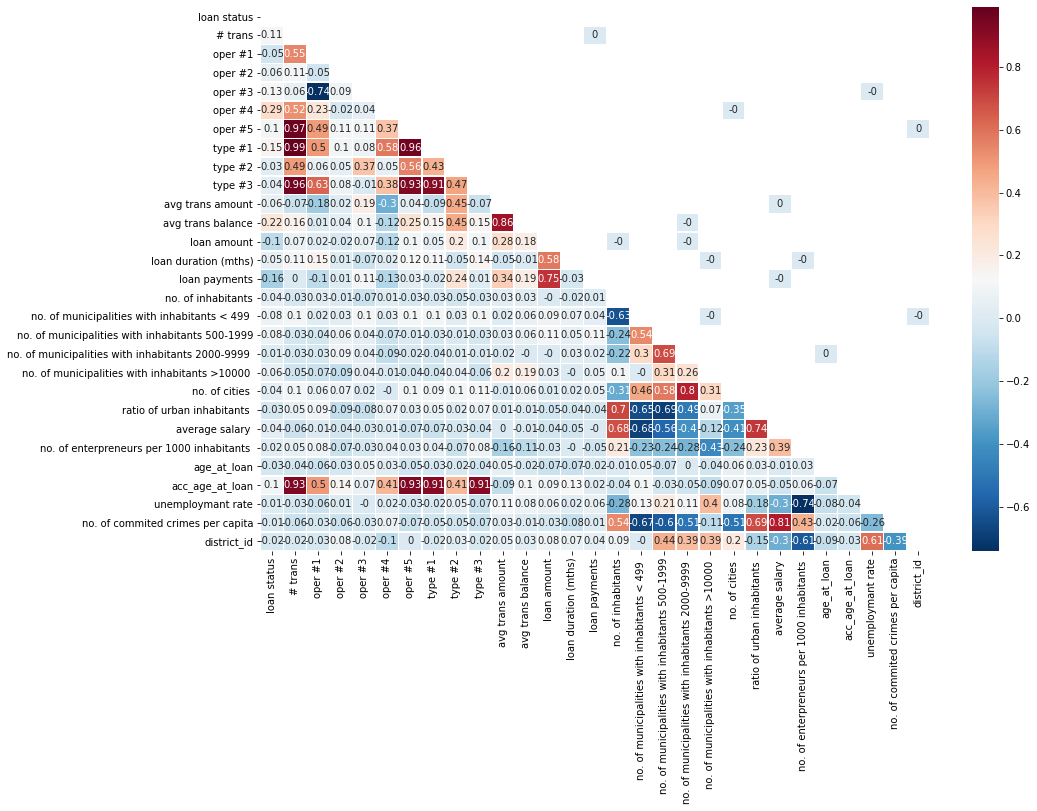

In [122]:
fig, ax = plt.subplots(figsize=(15,10)) 

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(spearmancorr)

sns.heatmap(spearmancorr, 
            xticklabels=spearmancorr.columns,
            yticklabels=spearmancorr.columns,
            cmap='RdBu_r',
            linewidth=0.5,
            annot=True,
            ax=ax,
           mask=matrix)

#### Remarks

## 1.6 Data Visualization: Bivariate/Multivariate Graphs

### N Transactions / Operations / Types 

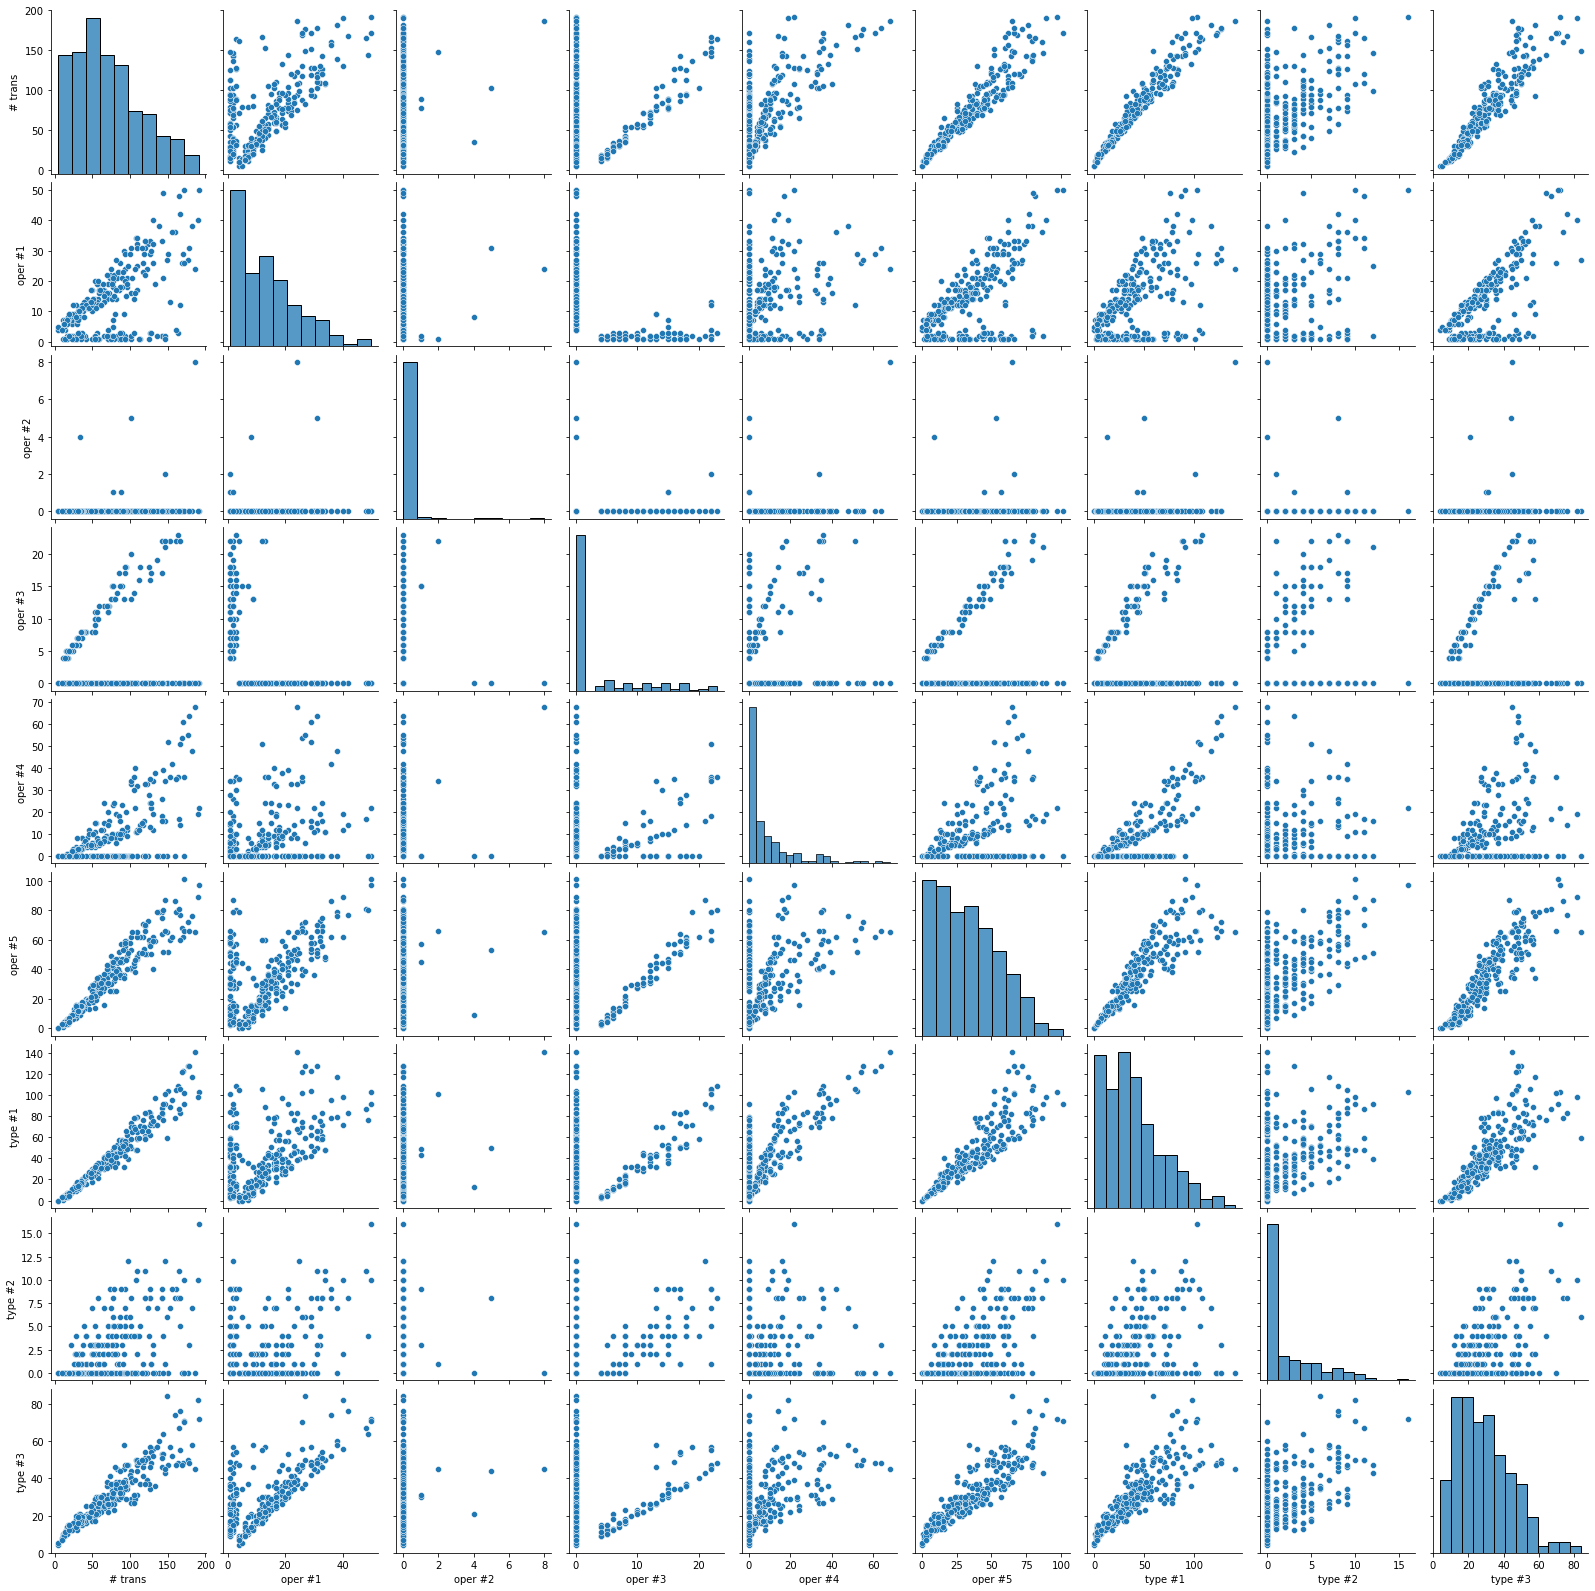

In [123]:
sns.pairplot(df_num[['# trans', 'oper #1', 'oper #2', 'oper #3', 'oper #4', 'oper #5', 'type #1', 'type #2', 'type #3']])

### avg trans amount / avg trans balance

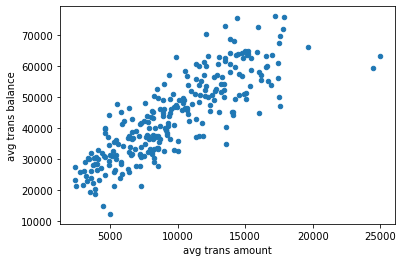

In [124]:
complete[['avg trans amount', 'avg trans balance']].plot.scatter(x="avg trans amount", y="avg trans balance");

#### Remarks:
Transaction amount seems to be almost 'proporcional' to the balance.

<IPython.core.display.Javascript object>


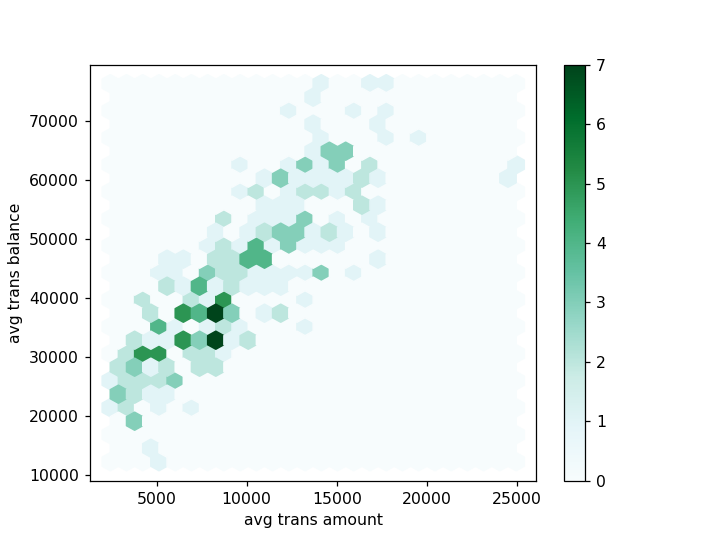

In [174]:
#fig, ax = plt.subplots()
complete[['avg trans amount', 'avg trans balance']].plot.hexbin(x="avg trans amount", y="avg trans balance", gridsize=25);
plt.show()

#### Remarks:
Higher concentration around the 30-40k avg balance and 7-10k amount.
Existence of a very small amount of transactions with a higher (around 1.7x the avg transaction amount for the same balance).

### loan amount / avg trans amount / avg trans balance

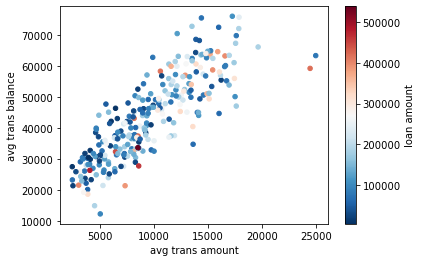

In [126]:
fig, ax = plt.subplots()
complete.plot(kind='scatter',x='avg trans amount', y='avg trans balance', c='loan amount', colormap='RdBu_r', ax=ax)
plt.show()

<IPython.core.display.Javascript object>


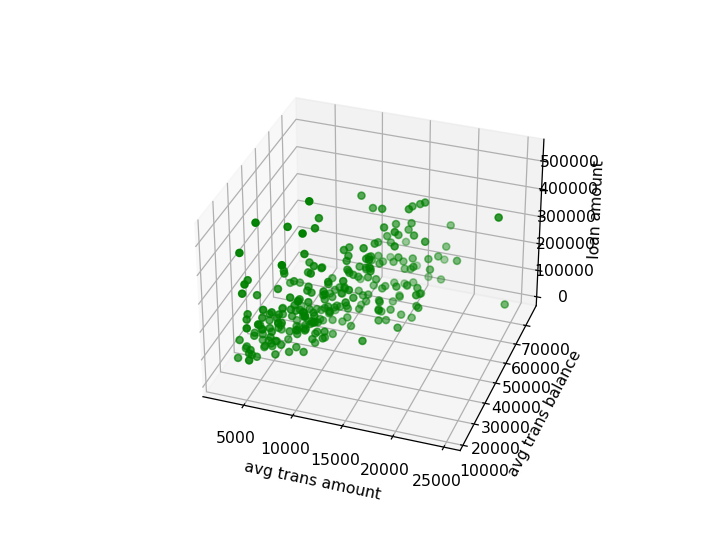

In [156]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(complete['avg trans amount'], complete['avg trans balance'], complete["loan amount"], c='g', marker='o')

ax.set_xlabel('avg trans amount')
ax.set_ylabel('avg trans balance')
ax.set_zlabel('loan amount')


plt.show()

### loan duration (mths) / loan amount

<IPython.core.display.Javascript object>


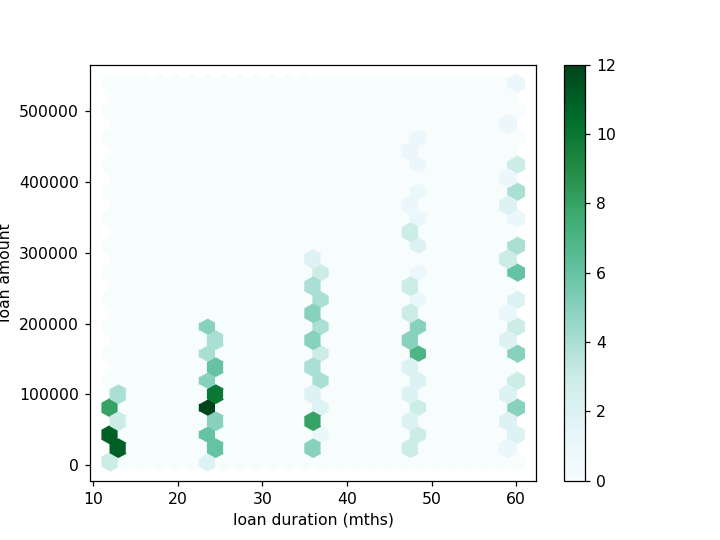

In [160]:
complete[['loan duration (mths)', 'loan amount']].plot.hexbin(x='loan duration (mths)', y='loan amount', gridsize=25);

#### Remarks:
Loan duration is (as expected) related with the loan amount. And a higher concentration of smaller loans is evident.

### loan payments / avg trans amount, avg trans balance, loan amount

<IPython.core.display.Javascript object>


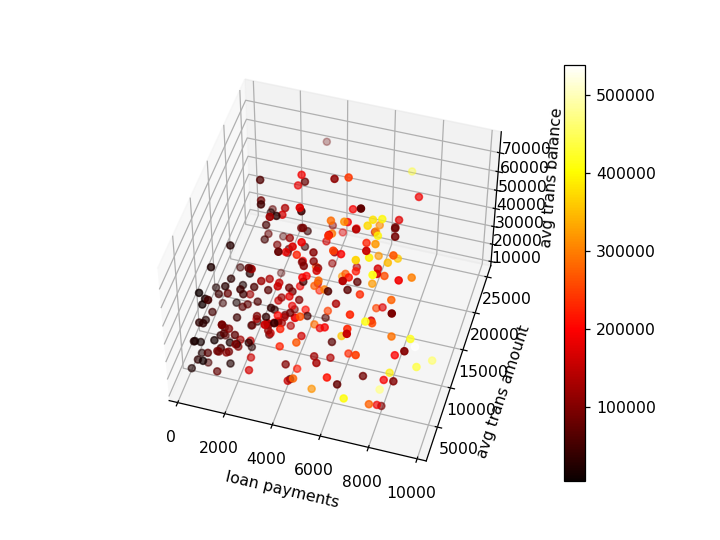

In [161]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = complete['loan payments']
y = complete['avg trans amount']
z = complete['avg trans balance']
c = complete['loan amount']

ax.set_xlabel('loan payments')
ax.set_ylabel('avg trans amount')
ax.set_zlabel('avg trans balance')

img = ax.scatter(x, y, z, c=c, cmap=plt.hot())
fig.colorbar(img)
plt.show()

#### Remarks:
loan amount increase seem to imply higher loan payments as expected

### loan status / loan amount, loan payments

<IPython.core.display.Javascript object>


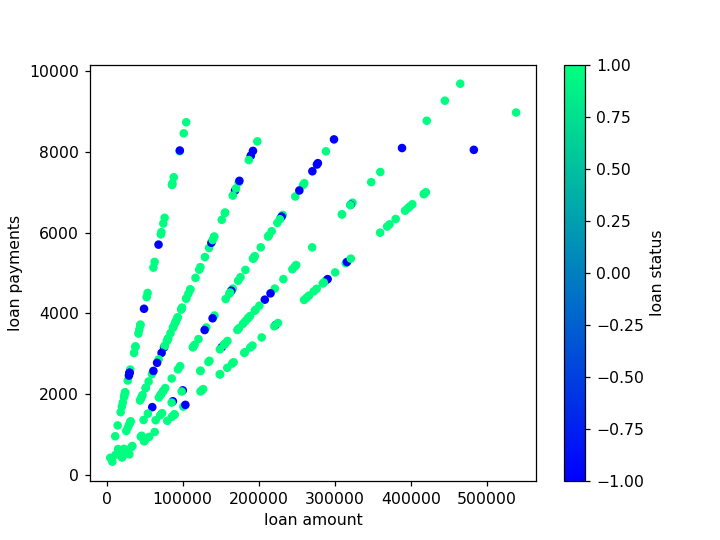

In [171]:
fig, ax = plt.subplots()
complete.plot(kind='scatter',x='loan amount', y='loan payments', c='loan status', colormap='winter', ax=ax)
plt.show()

<IPython.core.display.Javascript object>


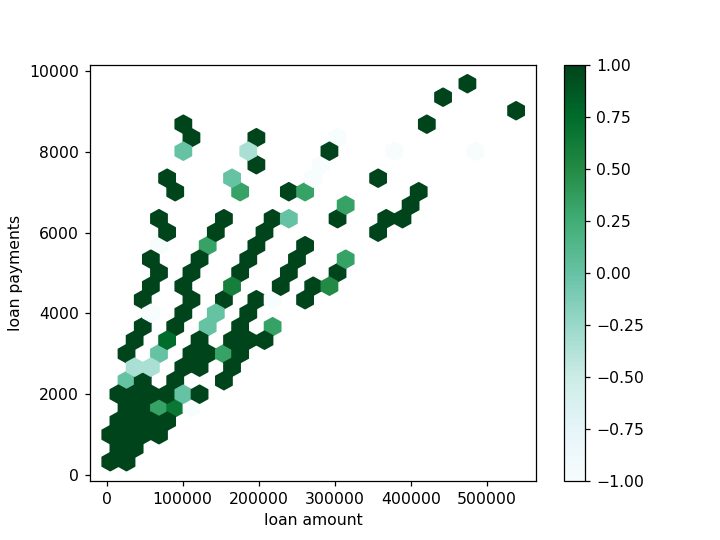

In [162]:
complete[['loan amount', 'loan payments', 'loan status']].plot.hexbin(x='loan amount', y='loan payments', C='loan status', gridsize=25);

### no. of cities / no. of inhabitants

<IPython.core.display.Javascript object>


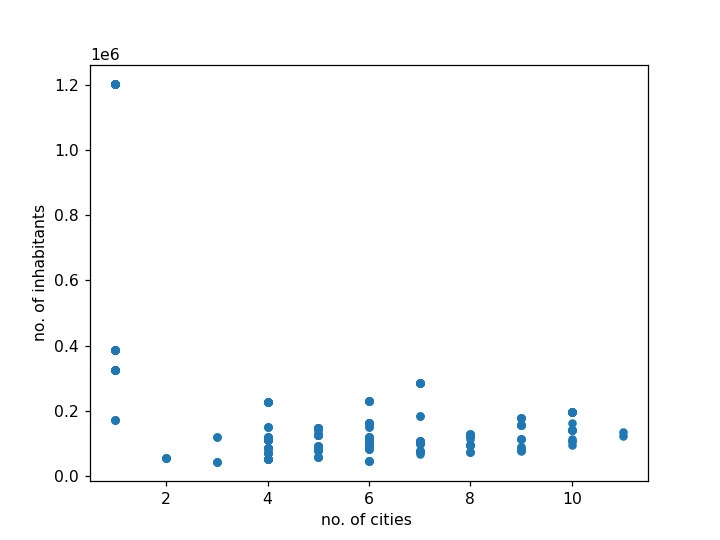

In [163]:
complete[['no. of cities ', 'no. of inhabitants']].plot.scatter(x='no. of cities ', y='no. of inhabitants');

### ratio of urban inhabitants / no. of inhabitants, no. of cities

<IPython.core.display.Javascript object>


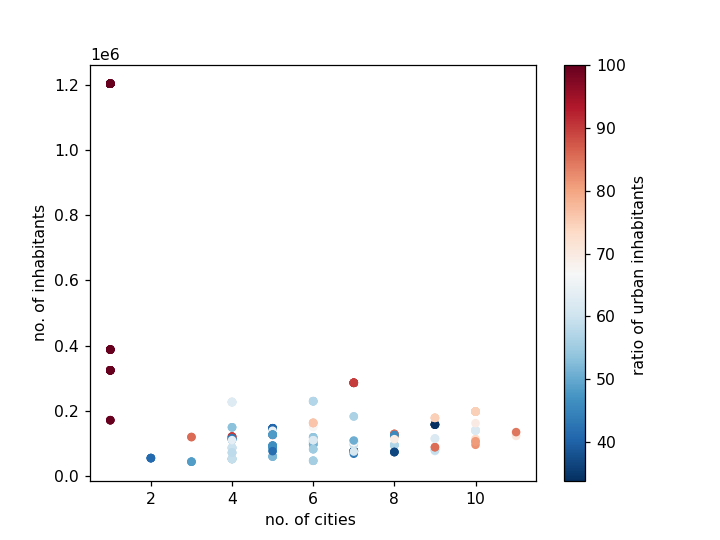

In [164]:
fig, ax = plt.subplots()
complete.plot(kind='scatter',x='no. of cities ', y='no. of inhabitants', c='ratio of urban inhabitants ', colormap='RdBu_r', ax=ax)
ax.set_ylabel("no. of inhabitants")
plt.show()

### avg salary / no. of inhabitants, no. of cities, ratio of urban inhabitants

<IPython.core.display.Javascript object>


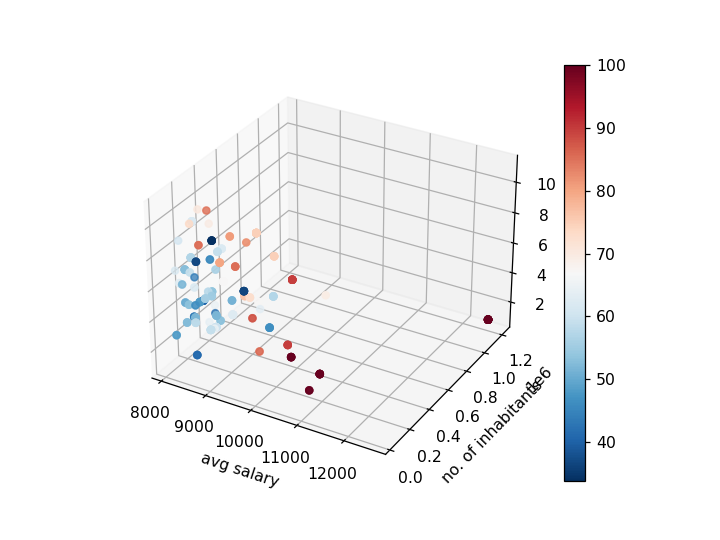

In [165]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = complete['average salary ']
y = complete['no. of inhabitants']
z = complete['no. of cities ']
c = complete['ratio of urban inhabitants ']

ax.set_xlabel('avg salary')
ax.set_ylabel('no. of inhabitants')
ax.set_zlabel('no. of cities')

img = ax.scatter(x, y, z, c=c, cmap='RdBu_r')
fig.colorbar(img)
plt.show()

### enterpreneurs / no. of inhabitants, ratio of urban inhabitants, avg salary

<IPython.core.display.Javascript object>


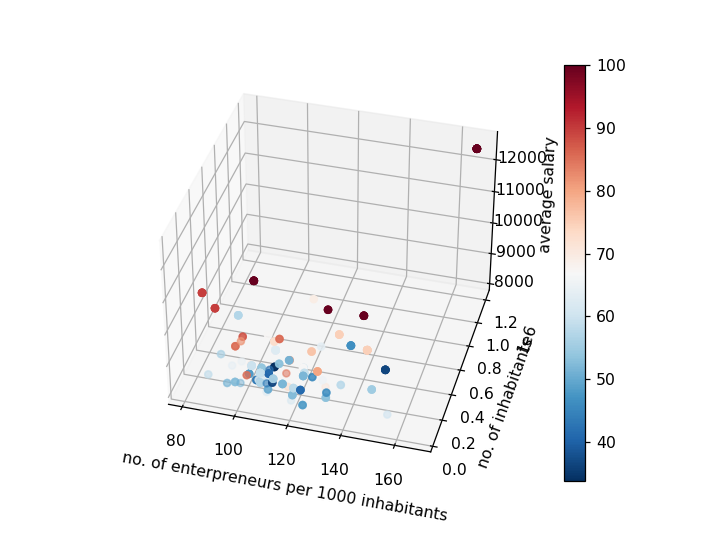

In [166]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = complete['no. of enterpreneurs per 1000 inhabitants ']
y = complete['no. of inhabitants']
z = complete['average salary ']
c = complete['ratio of urban inhabitants ']

ax.set_xlabel('no. of enterpreneurs per 1000 inhabitants')
ax.set_ylabel('no. of inhabitants')
ax.set_zlabel('average salary')

img = ax.scatter(x, y, z, c=c, cmap='RdBu_r')
fig.colorbar(img)
plt.show()

### unemploymant rate / no. of inhabitants, avg salary, enterpreneurs

<IPython.core.display.Javascript object>


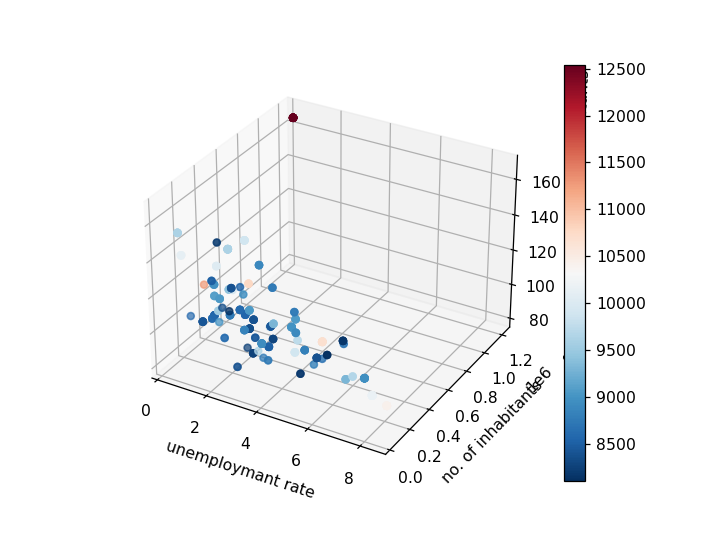

In [167]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = complete['unemploymant rate']
y = complete['no. of inhabitants']
z = complete['no. of enterpreneurs per 1000 inhabitants ']
c = complete['average salary ']

ax.set_xlabel('unemploymant rate')
ax.set_ylabel('no. of inhabitants')
ax.set_zlabel('no. of enterpreneurs per 1000 inhabitants')

img = ax.scatter(x, y, z, c=c, cmap='RdBu_r')
fig.colorbar(img)
plt.show()

### crimes / no. of cities, no. of inhabitants, ratio of urban inhabitants, avg salary, unemployment

<IPython.core.display.Javascript object>


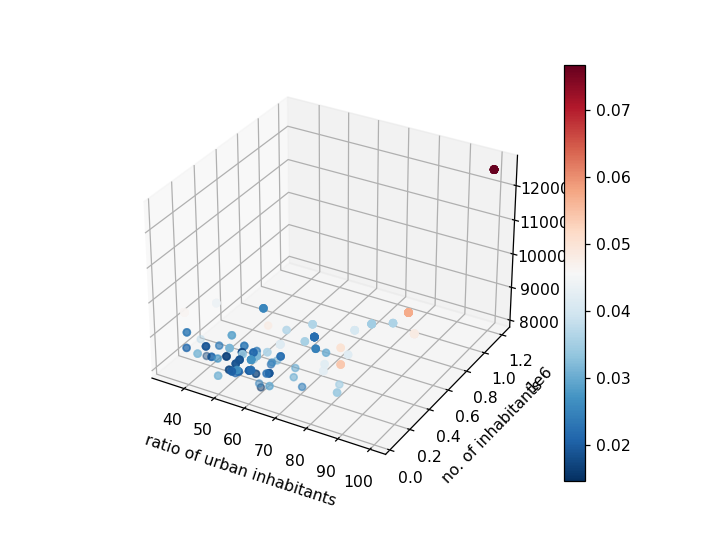

In [168]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = complete['ratio of urban inhabitants ']
y = complete['no. of inhabitants']
z = complete['average salary ']
c = complete['no. of commited crimes per capita']

ax.set_xlabel('ratio of urban inhabitants')
ax.set_ylabel('no. of inhabitants')
ax.set_zlabel('average salary')

img = ax.scatter(x, y, z, c=c, cmap='RdBu_r')
fig.colorbar(img)
plt.show()

<IPython.core.display.Javascript object>


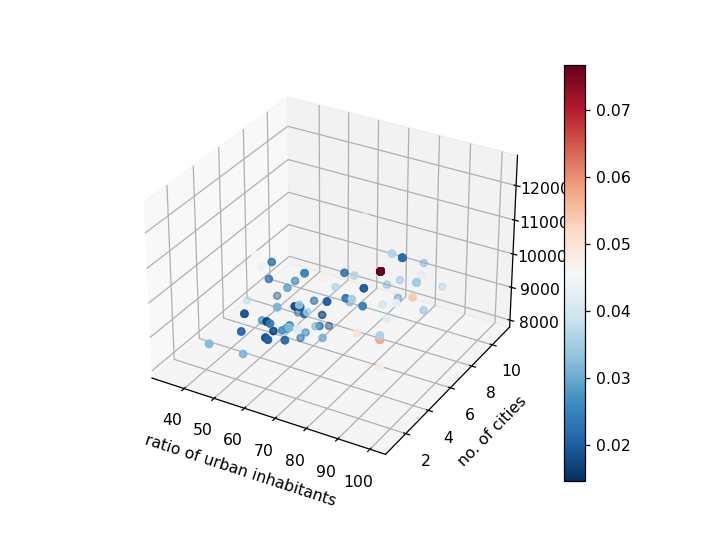

In [169]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = complete['ratio of urban inhabitants ']
y = complete['no. of cities ']
z = complete['average salary ']
c = complete['no. of commited crimes per capita']

ax.set_xlabel('ratio of urban inhabitants')
ax.set_ylabel('no. of cities')
ax.set_zlabel('average salary')

img = ax.scatter(x, y, z, c=c, cmap='RdBu_r')
fig.colorbar(img)
plt.show()

<IPython.core.display.Javascript object>


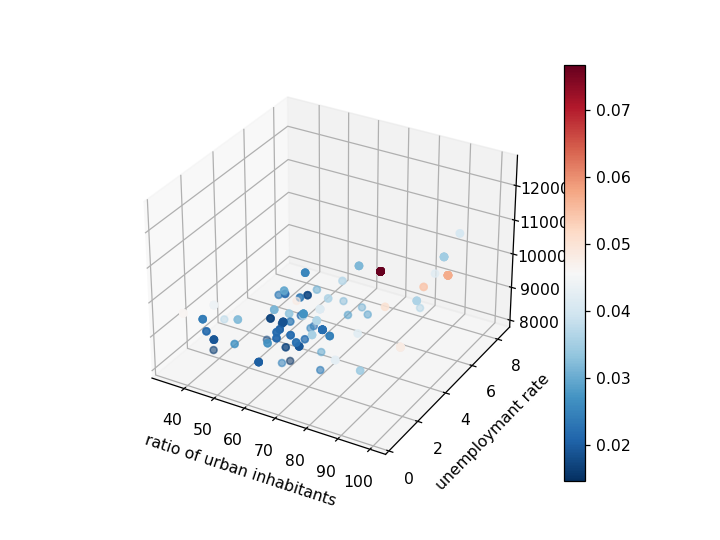

In [170]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = complete['ratio of urban inhabitants ']
y = complete['unemploymant rate']
z = complete['average salary ']
c = complete['no. of commited crimes per capita']

ax.set_xlabel('ratio of urban inhabitants')
ax.set_ylabel('unemploymant rate')
ax.set_zlabel('average salary')

img = ax.scatter(x, y, z, c=c, cmap='RdBu_r')
fig.colorbar(img)
plt.show()

# Data Visualization Experiments

In [140]:
temp = complete[['sex', 'loan status']]

In [141]:
sns.swarmplot(x="loan amount", y="sex", data=complete[['sex', 'loan amount']])

<Axes3DSubplot:xlabel='loan amount', ylabel='sex'>

In [142]:
ax = sns.swarmplot(x="loan status", y="average salary ", hue="sex", data=complete[['average salary ', 'loan status', 'sex']])

<IPython.core.display.Javascript object>


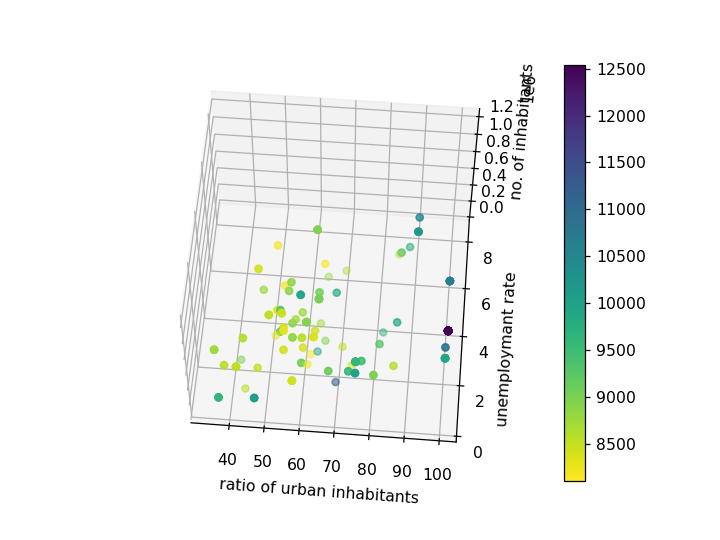

In [143]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = complete['ratio of urban inhabitants ']
y = complete['unemploymant rate']
z = complete['no. of inhabitants']
c = complete['average salary ']

ax.set_xlabel('ratio of urban inhabitants')
ax.set_ylabel('unemploymant rate')
ax.set_zlabel('no. of inhabitants')

img = ax.scatter(x, y, z, c=c, cmap='viridis_r')
fig.colorbar(img)
plt.show()

<IPython.core.display.Javascript object>


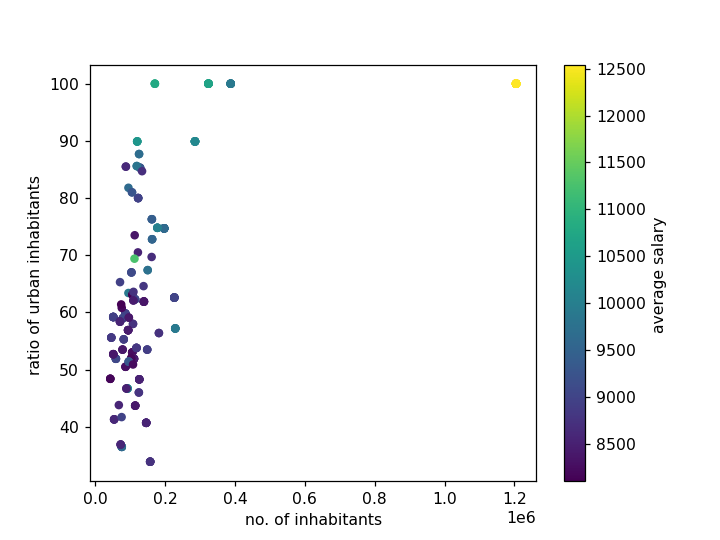

In [144]:

fig, ax = plt.subplots()
complete.plot(kind='scatter',x='no. of inhabitants', y='ratio of urban inhabitants ', c='average salary ', colormap='viridis', ax=ax)
ax.set_xlabel("no. of inhabitants")
plt.show()



<IPython.core.display.Javascript object>


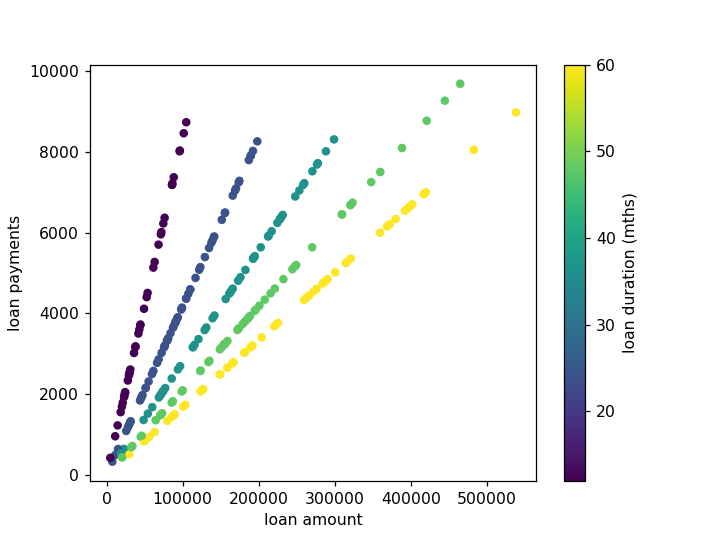

In [145]:
# Number of transactions, loan amount, avg amount per transaction

fig, ax = plt.subplots()
complete.plot(kind='scatter',x='loan amount', y='loan payments', c='loan duration (mths)', colormap='viridis', ax=ax)
ax.set_xlabel("loan amount")
plt.show()

<IPython.core.display.Javascript object>


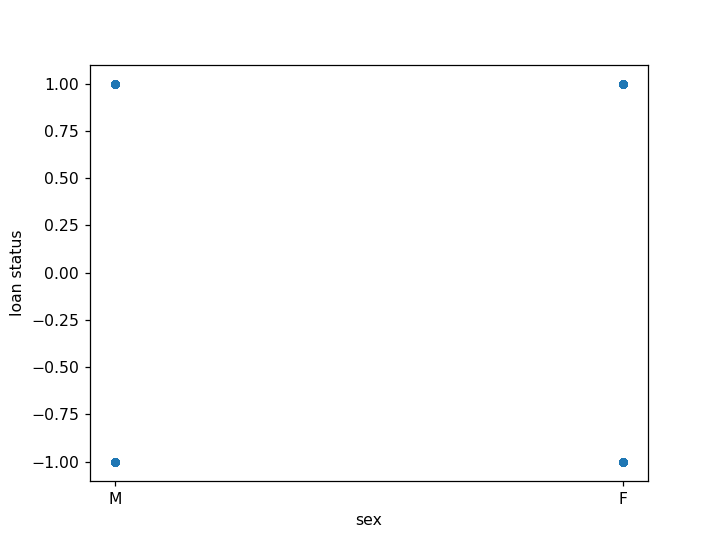

In [146]:
complete['payment_duration'] = complete['loan duration (mths)'] * complete['loan payments']

#fig, ax = plt.subplots()
#complete.plot(kind='scatter',x='payment_duration', y='loan amount')
complete.plot(kind='scatter',x='sex', y='loan status')
#ax.set_xlabel("loan amount")
plt.show()

complete = complete.drop(columns=['payment_duration'])

<IPython.core.display.Javascript object>


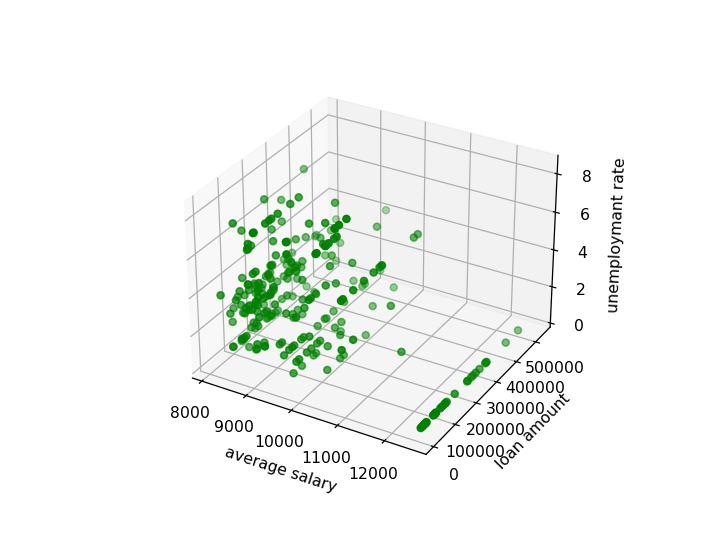

In [147]:
# %matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.scatter(complete['average salary '], complete['loan amount'], complete["unemploymant rate"], c='g', marker='o')

ax.set_xlabel('average salary')
ax.set_ylabel('loan amount')
ax.set_zlabel('unemploymant rate')


plt.show()

#### Missing Values

In [148]:
total = complete.isnull().sum().sort_values(ascending=False)
percent = (complete.isnull().sum()/complete.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
print("Total number of rows: ", end=""); print(complete.shape[0])
missing_data.head(10)

Total number of rows: 268


Total  Percent
district_id                            0      0.0
no. of commited crimes per capita      0      0.0
loan amount                            0      0.0
loan date                              0      0.0
avg trans balance                      0      0.0
avg trans amount                       0      0.0
type #3                                0      0.0
type #2                                0      0.0
type #1                                0      0.0
oper #5                                0      0.0

In [149]:
corr = complete.corr()['loan status']
corr

loan status                                          1.000000
# trans                                              0.104216
oper #1                                             -0.031793
oper #2                                              0.049094
oper #3                                              0.142081
oper #4                                              0.185347
oper #5                                              0.081382
type #1                                              0.140228
type #2                                              0.052772
type #3                                              0.024159
avg trans amount                                     0.063329
avg trans balance                                    0.223042
loan amount                                         -0.092365
loan duration (mths)                                 0.049515
loan payments                                       -0.166712
no. of inhabitants                                  -0.009761
no. of m

In [150]:
#sns.heatmap(complete.corr(method='pearson'))

<IPython.core.display.Javascript object>


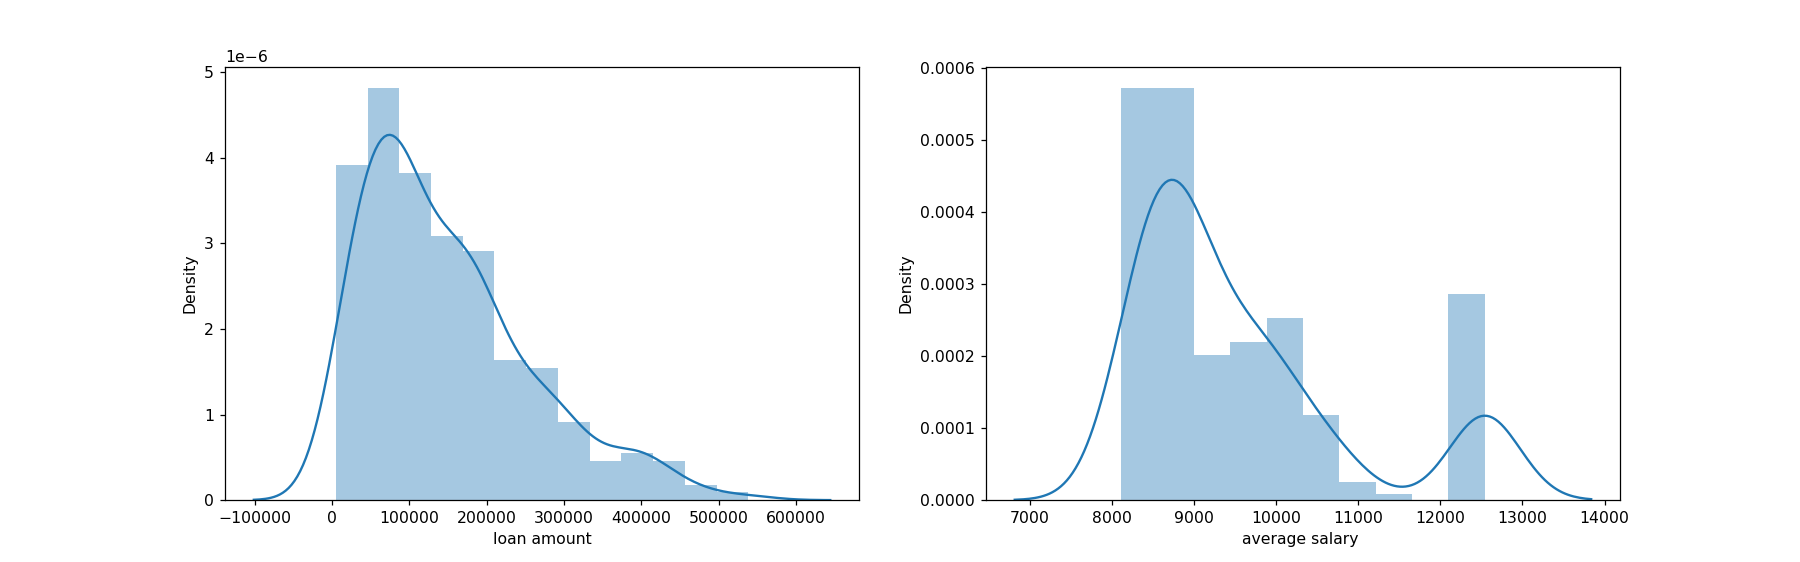

In [151]:
mpl.rcParams.update(mpl.rcParamsDefault)
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
sns.distplot(complete['loan amount'])
plt.subplot(1,2,2)
sns.distplot(complete['average salary '])
plt.show()

In [152]:
# Finding how many 
df_mask = complete['average salary '] > 12000
# print(len(complete[df_mask].index))
display(complete[df_mask].shape)
display(complete.shape)
print("{}%".format(complete[df_mask].shape[0] / complete.shape[0] * 100))

display(complete[df_mask])

(34, 36)

(268, 36)

12.686567164179104%


loan status                   frequency   acc date  # trans  oper #1  \
loan_id                                                                         
4959               1            monthly issuance 1993-02-26     54.0      2.0   
6499               1            monthly issuance 1993-02-26     54.0      2.0   
5479               1            monthly issuance 1993-02-27     73.0     21.0   
6960               1            monthly issuance 1993-03-13    153.0     13.0   
5724              -1            monthly issuance 1993-03-24    139.0     38.0   
6919               1             weekly issuance 1993-03-27     96.0     21.0   
6229               1            monthly issuance 1993-04-22    133.0     19.0   
7220               1             weekly issuance 1993-05-29     83.0      2.0   
5576               1            monthly issuance 1993-05-30    120.0     33.0   
6038               1            monthly issuance 1993-06-21     57.0     19.0   
6820               1            monthly issuance 1993-06-28     29.0      2.0   
7241              -1            monthly issuance 1993-08-10    160.0     36.0   
7142              -1            monthly issuance 1993-08-29    130.0     26.0   
6546               1            monthly issuance 1993-09-05    117.0     23.0   
6736               1  issuance after transaction 1994-02-27     10.0      4.0   
6244              -1             weekly issuance 1994-03-07     72.0     16.0   
5739               1            monthly issuance 1994-05-01     45.0     12.0   
7057               1             weekly issuance 1994-07-01    126.0      3.0   
6785               1             weekly issuance 1994-09-05    127.0     29.0   
5740               1            monthly issuance 1994-11-25     13.0      5.0   
5429               1            monthly issuance 1995-02-11     96.0     18.0   
7008               1            monthly issuance 1995-03-04     36.0      2.0   
5635               1            monthly issuance 1995-03-11     77.0     20.0   
6309               1            monthly issuance 1995-05-08     63.0     17.0   
7304               1             weekly issuance 1995-05-26     18.0      2.0   
6185               1            monthly issuance 1995-06-08     23.0      7.0   
6698               1             weekly issuance 1995-08-08     50.0     11.0   
6063              -1            monthly issuance 1995-08-18     50.0      1.0   
7194               1            monthly issuance 1995-10-23     53.0     14.0   
6817               1            monthly issuance 1996-01-05     53.0     11.0   
6012               1             weekly issuance 1996-01-11     16.0      7.0   
5385               1            monthly issuance 1996-01-13     31.0      9.0   
5375               1            monthly issuance 1996-02-01     38.0     10.0   
6940               1            monthly issuance 1996-06-09     20.0      8.0   

         oper #2  oper #3  oper #4  oper #5  type #1  type #2  type #3  \
loan_id                                                                  
4959         0.0     10.0      5.0     27.0     29.0      3.0     22.0   
6499         0.0     10.0      5.0     27.0     29.0      3.0     22.0   
5479         0.0      0.0      0.0     42.0     33.0      9.0     31.0   
6960         0.0     22.0     36.0     60.0     89.0      7.0     57.0   
5724         0.0      0.0      0.0     79.0     79.0      0.0     60.0   
6919         0.0      0.0     12.0     48.0     56.0      4.0     36.0   
6229         0.0      0.0     38.0     59.0     97.0      0.0     36.0   
7220         0.0     14.0     10.0     44.0     53.0      1.0     29.0   
5576         0.0      0.0      0.0     69.0     61.0      8.0     51.0   
6038         0.0      0.0      5.0     24.0     25.0      4.0     28.0   
6820         0.0      6.0      4.0      7.0     10.0      1.0     18.0   
7241         0.0      0.0      0.0     86.0     78.0      8.0     74.0   
7142         0.0      0.0     34.0     40.0     74.0    

#### Remarks:
Considerable fraction of the data, therefore not taken as outliers.